In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-23 20:00:00   278.65   278.75  278.50    278.50     3590.0
2022-02-23 19:58:00   278.65   278.65  278.65    278.65      718.0


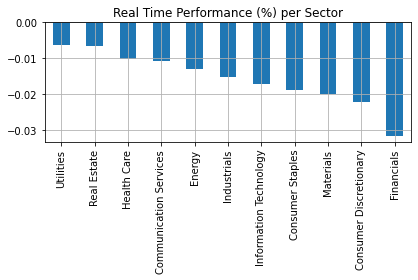

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

122.0700


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
135     DGRO
136     TD6C
137     TDG0
138    PTTRX
139      NaN
Name: Ticker, Length: 140, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
15-Feb - UP (43.6000)
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb - UP (203.5800)
16-Mar
04-Feb - UP (64.9900)
17-Feb - UP (55.6500)
27-Jan - UP (319.1700)
09-Feb - UP (8.8500)
14-Mar
09-Mar
17-Feb - UP (78.4600)
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
22-Feb - DN (124.0600)
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb - UP (80.9100)
17-Feb - DN (182.4200)
09-Feb - UP (205.9100)
09-Feb - UP (152.1600)
28-Feb
23-Feb
16-Feb - DN (9.7000)
16-Feb - DN (746.8500)
26-Jan - UP (228.2200)
15-Feb - DN (89.0600)
23-Feb
28-Feb
23-Feb
08-Feb - UP (8.5800)
22-Feb - DN (61.4600)
15-Feb - UP (61.9700)
15-Feb - UP (11.8800)
28-Feb
08-Feb - UP (364.9400)
03-Feb - UP (138.1800)
08-Feb - UP (37.2700)
10-Feb - DN (51.3400)
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb - DN (12.7600)
21-Mar
08-Mar
02-Mar
23-Feb
10-Feb - UP (629.8000)
23-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
17-Feb

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [28]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTALCURRENTASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [36]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FIRST QUARTER", "SECOND QUARTER", "THIRD QUARTER", "FOURTH QUARTER", "FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if (str(x) != "%" and str(x) != "%)") else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [37]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [146]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          


FINAL REPORT
            METRIC FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $162 - $167           

  FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                          97 - 103%         
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
           METRIC MARGIN FOURTH QUARTER FISCAL 2021 NON-GAAP GUIDANCE
6  OPERATING LOSS                                                (30 
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                              METRIC  \
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

  AMOUNT (MILLIONS) FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE  
9                                                283          

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1      


FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2021 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            68%
7           OPERATING LOSS                                          (40%)
9  ADJUSTED FREE CASH FLOW                                          (18%)
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

   AMOUNT (MILLIONS) FULL-YEAR FISCAL 2021 GAAP GUIDANCE  
12                                                255     

FOR TABLE 3

TABLE DESCRIPTION:  
ORIGINAL TABLE  3
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                             

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC OCTOBER 31, 2020  \
2                                              ASSETS              nan   
3                                      CURRENT ASSETS              nan   
4                           CASH AND CASH EQUIVALENTS         $3939925   
5                              SHORT-TERM INVESTMENTS           814123   
6                            ACCOUNTS RECEIVABLE, NET           168982   
7                       DEFERRED COMMISSIONS, CURRENT            28063   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS            35678   
9                                TOTAL CURRENT ASSETS          4986771   
10                              LONG-TERM INVESTMENTS           347403   
11                        PROPERTY AND EQUIPMENT, NET            53650   
12                OPERATING LEASE RIGHT-OF-USE ASSETS           189255   
13                                      

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem__
    indexer = self.c

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, in getOneTable
    report


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
18                               PRODUCT GROSS MARGIN   
19       PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                                 TOTAL GROSS MARGIN   
22               


FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                            PRODUCT GROSS MARGIN   
19    PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                              TOTAL GROSS MARGIN   
22                              OPERATING EXPENSES   
23            

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [79]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Quote for stock ENB on earning date 15-Feb - UP (43.6000) already generated
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Quote for stock KNSL on earning date 17-Feb - UP (203.5800) already generated
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Quote for stock APPN on earning date 17-Feb - UP (55.6500) already generated
Quote for stock TEAM on earning date 27-Jan - UP (319.1700) already generated
Quote for stock CGC on earning date 09-Feb - UP (8.8500) already gener

0 NaN  $  27156 NaN  $  25572  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 6

TABLE DESCRIPTION: <BR/>
ORIGINAL TABLE  6
                                                  0  \
0                                     ZSCALER, INC.   
1             Condensed Consolidated Balance Sheets   
2                                    (in thousands)   
3                                       (unaudited)   
4                                               NaN   
5                                               NaN   
6                                            Assets   
7                                   Current assets:   
8                         Cash and cash equivalents   
9                            Short-term investments   
10                         Accounts receivable, net   
11              Deferred contract acquisition costs   
12        Prepaid expenses and other current assets   
13                             Total current assets   
14                      Property an

{3: [4, 4], 11: [12, 12]}
EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-36-17859192296b>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem

EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-36-17859192296b>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem__
    indexer = self.colu

FINAL REPORT
                                             METRIC  \
8                                            ASSETS   
9                                    CURRENT ASSETS   
10                        CASH AND CASH EQUIVALENTS   
11                           SHORT-TERM INVESTMENTS   
12                         ACCOUNTS RECEIVABLE, NET   
13                 PREPAID AND OTHER CURRENT ASSETS   
14             FUNDS RECEIVABLE AND SELLER ACCOUNTS   
15                             TOTAL CURRENT ASSETS   
16                                  RESTRICTED CASH   
17                      PROPERTY AND EQUIPMENT, NET   
18                                         GOODWILL   
19                           INTANGIBLE ASSETS, NET   
20                              DEFERRED TAX ASSETS   
21                            LONG-TERM INVESTMENTS   
22                                     OTHER ASSETS   
23                                     TOTAL ASSETS   
24             LIABILITIES AND STOCKHOLDERS' EQUITY 

{}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                          NET INCOME   
10  ADJUSTMENTS TO RECONCILE NET INCOME TO NET CAS...   
11                   STOCK-BASED COMPENSATION EXPENSE   
12              DEPRECIATION AND AMORTIZATION EXPENSE   
13               PROVISION FOR EXPECTED CREDIT LOSSES   
14                       FOREIGN EXCHANGE (GAIN) LOSS   
15                AMORTIZATION OF DEBT ISSUANCE COSTS   
16                          NON-CASH INTEREST EXPENSE   
17          INTEREST EXPENSE ON MARKETABLE SECURITIES   
18      DEFERRED (BENEFIT) PROVISION FOR INCOME TAXES   
19                     LOSS ON EXTINGUISHMENT OF DEBT   
20                         OTHER NON-CASH INCOME, NET   
21  CHANGES IN OPERATING ASSETS AND LIABILITIES (N...   
22          NET CASH PROVIDED BY OPERATING ACTIVITIES   
23               CASH FLOWS FROM INVESTING ACTIVITIES   
24    ACQUISIT

FOR TABLE 10

TABLE DESCRIPTION: 32%
ORIGINAL TABLE  10
     0                                                  1
0  NaN                                                NaN
1  (1)  Included in interest and other non-operating e...
2  NaN                                                NaN
3  (2)  Included in depreciation and amortization is a...
4  NaN                                                NaN
5  (3)  Foreign exchange (gain) loss is primarily driv...
6  NaN                                                NaN
7  (4)  Acquisition-related expenses for the three and...
8  NaN                                                NaN
9  (5)  During the third quarter of 2020, we repurchas...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
           Symbol  Last Price  Change % Change
0  ETSYEtsy, Inc.      128.16   11.65  +10.00%
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND
Earning report for stock ETSY fetching status True, 

Earning report for stock VIR fetching status True, filename VIR-2022-02-24_17-35-45.801575.txt
Earning report for stock VIR on date 2022-02-24 fetched, filename VIR-2022-02-24_17-35-45.801575.txt
Earning released for stock VIR AH
Get price diff for stock VIR from date 2022-02-24 and date 2022-02-25
Update Stock VIR with quote 24-Feb
Quote for stock CMG on earning date 08-Feb - UP (1608.7400) already generated
Quote for stock ACB on earning date 10-Feb - DN (4.4900) already generated
Quote for stock JMIA on earning date 23-Feb - DN (7.5200) already generated
Earning report for stock BYND on date 2022-02-24 does not exist, trying to fetch it
https://finance.yahoo.com/news/beyond-meat-reports-fourth-quarter-210500602.html
TRYING TO STORE REFINED CONTENT IN FILE ../../Summary/Refined/BYND-2022-02-24_17-36-28.598836.txt
TRYING TO STORE TABLES IN FILE ../../Summary/report/BYND-REPORT-2022-02-24_17-36-28.598836.txt
NUMBER OF TABLES 13

FOR TABLE 0

TABLE DESCRIPTION: NET REVENUES BY CHANNEL:


{3: [4, 4]}

FINAL REPORT
                                               METRIC
5                                              ASSETS
6                                      CURRENT ASSETS
7                           CASH AND CASH EQUIVALENTS
8                            ACCOUNTS RECEIVABLE, NET
9                                           INVENTORY
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS
11                               TOTAL CURRENT ASSETS
12                PROPERTY, PLANT, AND EQUIPMENT, NET
13                OPERATING LEASE RIGHT-OF-USE ASSETS
14                   PREPAID LEASE COSTS, NON-CURRENT
15                      OTHER NON-CURRENT ASSETS, NET
16         INVESTMENT IN UNCONSOLIDATED JOINT VENTURE
17                                       TOTAL ASSETS
18                LIABILITIES AND STOCKHOLDERS EQUITY
19                                CURRENT LIABILITIES
20                                   ACCOUNTS PAYABLE
21                                      WAGES PAYABLE
22

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
2                              NET LOSS, AS REPORTED   
3             REPACKING COSTS ATTRIBUTABLE TO COVID-   
4  INVENTORY WRITE-OFFS AND RESERVES ATTRIBUTABLE...   
5  PRODUCT DONATIONS ATTRIBUTABLE TO COVID- RELIE...   
6                     LOSS ON EXTINGUISHMENT OF DEBT   
7                                  ADJUSTED NET LOSS   

  THREE MONTHS ENDED DECEMBER 31,2021 THREE MONTHS ENDED DECEMBER 31,2020  \
2                             $(80371                             $(25077   
3                                 nan                                 nan   
4                                 nan                                3719   
5                                 nan                                 nan   
6                                 nan                                 nan   
7                             $(80371                     


FOR TABLE 10

TABLE DESCRIPTION: THE FOLLOWING TABLE PRESENTS THE RECONCILIATION OF ADJUSTED EBITDA TO ITS MOST COMPARABLE GAAP MEASURE, NET LOSS, AS REPORTED (UNAUDITED):
ORIGINAL TABLE  10
                                        0   1                   2   \
0                                      NaN NaN  Three Months Ended   
1                           (in thousands) NaN    December 31,2021   
2                    Net loss, as reported NaN                   $   
3                       Income tax expense NaN                 NaN   
4                         Interest expense NaN                 NaN   
5    Depreciation and amortization expense NaN                 NaN   
6                Restructuring expenses(1) NaN                 NaN   
7         Share-based compensation expense NaN                 NaN   
8     Expenses attributable to COVID-19(2) NaN                 NaN   
9                            Other, net(3) NaN                 NaN   
10                         Adjusted EB

Earning report for stock CRM fetching status False, filename None
Quote for stock CRM on earning date 24-Feb not generated yet
Earning report for stock BABA on date 2022-02-24 exists
Earning released for stock BABA PM
Get price diff for stock BABA from date 2022-02-24 and date 2022-02-23
Update Stock BABA with quote 24-Feb
Quote for stock CFLT on earning date 10-Feb - DN (57.1800) already generated
Earning report for stock PLUG on date 2022-02-24 does not exist, trying to fetch it
Earning report for stock PLUG fetching status False, filename None
Quote for stock PLUG on earning date 24-Feb not generated yet
Quote for stock ZNGA on earning date 09-Feb - NC (9.1700) already generated
Earning for stock LULU will be released later on 2022-03-28
Quote for stock LULU on earning date 28-Mar not generated yet
Quote for stock NET on earning date 10-Feb - DN (104.9200) already generated
Earning report for stock BILI on date 2022-02-24 does not exist, trying to fetch it
Earning report for stock B

In [45]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [78]:
stocks = get_earningDates(d, "YT")
print(stocks, "\n", len(stocks))

[['HZNP', '24-Feb-2022'], ['ZS', '24-Feb-2022'], ['INTU', '24-Feb-2022'], ['EXPI', '24-Feb-2022'], ['CSPR', '24-Feb-2022'], ['DOCN', '24-Feb-2022'], ['WW', '24-Feb-2022'], ['SQ', '24-Feb-2022'], ['PUBM', '24-Feb-2022'], ['ETSY', '24-Feb-2022'], ['VIR', '24-Feb-2022'], ['BYND', '24-Feb-2022'], ['CRM', '24-Feb-2022'], ['BABA', '24-Feb-2022'], ['PLUG', '24-Feb-2022'], ['BILI', '24-Feb-2022']] 
 16


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [49]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [50]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [51]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [52]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [53]:
import json
org = "CRWD"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/CRWD/profile?p=CRWD
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/insider-transactions?p=CRWD
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/insider-roster?p=CRWD
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/holders?p=CRWD
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 1.46%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 72.06%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 73.13%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 1394
https://finance.yahoo.com/quote/CRWD/analysis?p=CRWD
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 1/30/2021 1 1 0.13
Table Number 2
FOUND
2 4/29/2021 1 2 0.1
Table Number 2
FOUND
3 7/30/2021 1 3 0.11
Table Number 2
FOUND
4 10/30/2021 1 4 0.17
Table Number 2
FOUND
1 1/30/2021 0 1 0.08
Table Number 2
FOUND
2 4/29/2021 0 2 0.06
Tab

In [80]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/0001713683/000171368322000025/zs-01312022_991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

11


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [54]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [55]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [56]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [57]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [58]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [59]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [60]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [61]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [62]:
def isBold(tag, ctext):
    listag = ["ul", "li"]
    if((tag.name == "b" and tag.parent.name not in listag) or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [63]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tags), ctag.name, ctag.text, tags)
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.name == "u"):
                continue
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [64]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [65]:
def isPadLeft(item):
    if(item.name == "ul" or item.name == "li"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [66]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [67]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    listag = ["ul", "li"]
    if not txt:
        if(item.name in listag):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", " ")
    ctext = ctext.replace("     ", " ")
    ctext = ctext.replace("    ", " ")
    ctext = ctext.replace("   ", " ")
    ctext = ctext.replace("  ", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name not in listag and item.parent.name not in listag):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [68]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [69]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle+" .")
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk]+" .")
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata+" .")
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr+" .")
    f.write("\n")
    return possibleTblTitle

In [70]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            eyr = eyr + emonth
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    hc = False #Header continue to next row
    dollarCol = list()
    f.write("\n")
    f.write(tblStr+" .")
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            hc = False
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met.upper() and "PER SHARE" not in met.upper() and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met.upper() or "EPS" in met.upper())):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
                hc = True
            else:
                if hc:
                    header = header + " " + met
                else:
                    header = met
        elif(met == "TOTAL"):
            header = None
        else:
            hc = False
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr+" .")
    f.write("\n")

In [71]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br", "li"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul" and len(tag.findChildren("li", recursive=True)) == 0):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "li" and len(tag.findChildren("li", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [72]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2020-12-02"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [81]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477333/000119312522034540/d243920dex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/0001713683/000171368322000025/zs-01312022_991.htm"
source = getPgSource(url)

In [82]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  ZSCALER WILL HOST A CONFERENCE CALL FOR ANALYSTS AND INVESTORS TO DISCUSS ITS SECOND QUARTER FISCAL 2022 EARNINGS RESULTS AND OUTLOOK FOR ITS THIRD QUARTER OF FISCAL 2022  AND FULL YEAR FISCAL 2022  TODAY A T 1:30 P.M. PACIFIC TIME (4:30 P.M. EASTERN TIME).
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                             3                            4  \
0                          NaN                          NaN   
1  Thursday, February 24, 2022  Thursday, February 24, 2022   
2                 1:30 p.m. PT                 1:30 p.m. PT   
3       https://ir.zscaler.com       https://ir.zscaler.com   
4                 

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
9                                             REVENUE   
10                                  COST OF REVENUE     
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                              SALES AND MARKETING     
14                         RESEARCH AND DEVELOPMENT     
15                       GENERAL AND ADMINISTRATIVE     
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   
18                                    INTEREST INCOME   
19                                  INTEREST EXPENSE    
20                        OTHER INCOME (EXPENSE), NET   
21                           LOSS BEFORE INCOME TAXES   
22                         PROVISION FOR INCOME TAXES   
23                             

HEADERSSSSSSSSS ['0:6']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
9                CASH FLOWS FROM OPERATING ACTIVITIES   
10                                           NET LOSS   
11  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
12              DEPRECIATION AND AMORTIZATION EXPENSE   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
15   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
16                     NON-CASH OPERATING LEASE COSTS   
17                   STOCK-BASED COMPENSATION EXPENSE   
18  AMORTIZATION OF INVESTMENT PREMIUMS, NET OF AC...   
19                              DEFERRED INCOME TAXES   
20                               IMPAIRMENT OF ASSETS   
21                                              OTHER   
22  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
23                                ACCOUNTS RECEIVABLE   
24    

HEADERSSSSSSSSS ['0:6']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11  STOCK-BASED COMPENSATION EXPENSE AND RELATED P...   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14         ASSET IMPAIRMENT RELATED TO FACILITY EXIT    
15   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
16                        PROVISION FOR INCOME TAXES    
17                                NON-GAAP NET INCOME   
19                   GAAP NET LOSS PER SHARE, DILUTED   
20  STOCK-BASED COMPENSATION EXPENSE AND RELATED P...   
22  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
23         ASSET IMPAIRMENT RELATED TO FACILITY EXIT    
24   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
25                        PROVISION FOR INCOME TAXES    
26  ADJ

In [83]:
allTables

{'TOTAL': 11,
 'PARSESUCCESS': [0, 1, 6, 7, 8, 9, 10],
 'PARSEFAIL': [2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Thursday, February 24, 2022","4":"Thursday, February 24, 2022","5":"Thursday, February 24, 2022"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com","4":"https:\\/\\/ir.zscaler.com","5":"https:\\/\\/ir.zscaler.com"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"918-922-3018","4":"918-922-3018","5":"918-922-3018"}]',
  'PARSE': [{'FIRSTCOLUMN': 'DATE:',
    'TABLEDESC': ' ZSCALER WILL HOST A CONFERENCE CALL FOR ANALYSTS AND INVESTORS TO DISCUSS ITS SECOND QUARTER FISCAL 2022 EARNINGS RESULTS AND OUTLOOK FOR ITS THIRD QUARTER OF FISCAL 2022  AND FULL YEAR FISCAL 2022  TODAY A T 1:30 P.M. PACIFIC TIME (4:30 P.M. EASTERN TIME).',
    'TABLENAME': 

In [84]:
csym = "ZS"
rptDest = "../../Summary/EDGAR/8-K/"+csym
textFilename = rptDest+"/ZS_2022-02-24_EP.txt"
testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
#testOne8KEdgarRpt(url, csym, None, source, allTables)

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** Zscaler Reports Second Quarter Fiscal 2022 Financial Results.


SC*** Second Quarter Highlights.


SC*** SAN JOSE, California - February 24, 2022 - Zscaler, Inc. (Nasdaq: ZS), the leader in cloud security, today announced financial results for its second quarter of fiscal year 2022, ended January 31, 2022.

NOPAD*** "Driven by continued demand for our Zero Trust security platform, we delivered strong results for the second quarter, with our year-over-year revenue growth rate reaching its highest level in three years, even as we surpassed $1 billion in annualized revenue,” said Jay Chaudhry, Chairman and CEO of Zscaler. "The importance of our Zero Trust Exchange architecture has never been clearer to customers undertaking digital transformation. Customers are not only gaining security advantages from our Zero Trust model but they are also reaping the benefits of faster innovation and economics from our global cloud, which is now processin

In [151]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [152]:
csym = "SNOW"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/SNOW'
1640147
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001628280-20-013752-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1640147/0001628280-20-013752-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000020-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm
NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                              

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC  \
7                    PRODUCT GROSS PROFIT   
12                         OPERATING LOSS   
13  NET CASH USED IN OPERATING ACTIVITIES   
14                         FREE CASH FLOW   
15                ADJUSTED FREE CASH FLOW   

   AMOUNT (MILLIONS) THIRD QUARTER FISCAL 2021 GAAP RESULTS  \
7                                               $96.7         
12                                           ($169.5)         
13                            

FINAL REPORT
            METRIC FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $162 - $167           

  FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                          97 - 103%         
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
           METRIC MARGIN FOURTH QUARTER FISCAL 2021 NON-GAAP GUIDANCE
6  OPERATING LOSS                                                (30 
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                              METRIC  \
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

  AMOUNT (MILLIONS) FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE  
9                                                283          

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1       

{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2021 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            68%
7           OPERATING LOSS                                          (40%)
9  ADJUSTED FREE CASH FLOW                                          (18%)
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

   AMOUNT (MILLIONS) FULL-YEAR FISCAL 2021 GAAP GUIDANCE  
12                                                255     

FOR TABLE 3

TABLE DESCRIPTION:  
ORIGINAL TABLE  3
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                           

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC OCTOBER 31, 2020  \
2                                              ASSETS              nan   
3                                      CURRENT ASSETS              nan   
4                           CASH AND CASH EQUIVALENTS         $3939925   
5                              SHORT-TERM INVESTMENTS           814123   
6                            ACCOUNTS RECEIVABLE, NET           168982   
7                       DEFERRED COMMISSIONS, CURRENT            28063   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS            35678   
9                                TOTAL CURRENT ASSETS          4986771   
10                              LONG-TERM INVESTMENTS           347403   
11                        PROPERTY AND EQUIPMENT, NET            53650   
12                OPERATING LEASE RIGHT-OF-USE ASSETS           189255   
13                                           GOODWILL           

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, i

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, in getOneTable
    report

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
1

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                            PRODUCT GROSS

NOPAD*** Document.


SC*** Snowflake Reports Financial Results for the Third Quarter of Fiscal 2021.

NOPAD*** SAN MATEO, Calif. - December 2, 2020 - Snowflake (NYSE: SNOW), provider of the Data Cloud, today announced financial results for its third quarter of fiscal 2021, ended October 31, 2020.

NOPAD*** Total revenue for the quarter was $159.6 million, representing 119% year-over-year growth. Product revenue was $148.5 million, representing 115% year-over-year growth. Remaining performance obligations were $927.9 million, representing 240% year-over-year growth. Net revenue retention rate was 162% as of October 31, 2020. The company now has 3,554 total customers and 65 customers with trailing 12-month product revenue greater than $1 million. See the section titled “Key Business Metrics” for definitions of product revenue, remaining performance obligations, net revenue retention rate, total customers, and customers with trailing 12-month product revenue greater than $1 million.

NOPA

8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000028-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000028-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000021-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1640147/000164014721000021/fy2021q4earnings.htm
NUMBER OF TABLES 12

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                           0   \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                             Product revenue   
4                                         NaN   
5                                         NaN   
6                                         NaN   
7                        Product gross profit   
8                                         NaN   
9                                         NaN   
10 


FINAL REPORT
            METRIC FULL-YEAR FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $553.8     

  FULL-YEAR FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               120%   
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC  \
7                    PRODUCT GROSS PROFIT   
12                         OPERATING LOSS   
13  NET CASH USED IN OPERATING ACTIVITIES   
14                         FREE CASH FLOW   
15                ADJUSTED FREE CASH FLOW   

   AMOUNT (MILLIONS) FULL-YEAR FISCAL 2021 GAAP RESULTS  \
7                                              $360.0     
12                                           ($543.9)     
13                                            ($45.4)     
14                                                nan     
15                                                nan     

   MARGIN FULL-YEAR FI

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC FULL-YEAR FISCAL 2022 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                      $1000 - $1020      

  FULL-YEAR FISCAL 2022 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                           81 - 84%    
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2022 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            71%
7           OPERATING LOSS                                          (19%)
9  ADJUSTED FREE CASH FLOW                                             0%
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

   AMOUNT (MILLIONS) FULL-YEAR FISCAL 2022 GAAP GUIDANCE  
12                                          

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JANUARY 31, 2021  \
2                                              ASSETS              nan   
3                                      CURRENT ASSETS              nan   
4                           CASH AND CASH EQUIVALENTS          $820177   
5                              SHORT-TERM INVESTMENTS          3087887   
6                            ACCOUNTS RECEIVABLE, NET           294017   
7                       DEFERRED COMMISSIONS, CURRENT            32371   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS            66200   
9                                TOTAL CURRENT ASSETS          4300652   
10                              LONG-TERM INVESTMENTS          1165275   
11                        PROPERTY AND EQUIPMENT, NET            68968   
12                OPERATING LEASE RIGHT-OF-USE ASSETS           186818   
13                                      

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, in getOneTable
    report


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
18                               PRODUCT GROSS MARGIN   
19       PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                                 TOTAL GROSS MARGIN   
22               

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16         PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                                 TOTAL GROSS PROFIT   
18                               PRODUCT GROSS MARGIN   
19       PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                                 TOTAL GROSS MARGIN   
22                

NOPAD*** Document.

NOPAD*** Snowflake Reports Financial Results for the Fourth Quarter and Full Year of Fiscal 2021.

NOPAD*** SAN MATEO, Calif. - March 3, 2021 - Snowflake (NYSE: SNOW), the Data Cloud company, today announced financial results for its fourth quarter and full year of fiscal 2021, ended January 31, 2021.

NOPAD*** Revenue for the quarter was $190.5 million, representing 117% year-over-year growth. Product revenue for the quarter was $178.3 million, representing 116% year-over-year growth. Remaining performance obligations were $1.3 billion, representing 213% year-over-year growth. Net revenue retention rate was 168% as of January 31, 2021. The company now has 4,139 total customers and 77 customers with trailing 12-month product revenue greater than $1 million. See the section titled “Key Business Metrics” for definitions of product revenue, remaining performance obligations, net revenue retention rate, total customers, and customers with trailing 12-month product reven

8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000103-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1640147/000164014721000103/fy2022q1earnings.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                           0   \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                             Product revenue   
4                                         NaN   
5                                         NaN   
6                                         NaN   
7                        Product gross profit   
8                                         NaN   
9                                         NaN   
10                                        NaN   
11                                        NaN   
12                             Operating loss   
13  Net cash provided by operating activities   
14       

FINAL REPORT
            METRIC FIRST QUARTER FISCAL 2022 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $213.8         

  FIRST QUARTER FISCAL 2022 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               110%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                       METRIC  \
7                        PRODUCT GROSS PROFIT   
12                             OPERATING LOSS   
13  NET CASH PROVIDED BY OPERATING ACTIVITIES   
14                             FREE CASH FLOW   
15                    ADJUSTED FREE CASH FLOW   

   AMOUNT (MILLIONS) FIRST QUARTER FISCAL 2022 GAAP RESULTS  \
7                                              $141.8         
12                                           ($205.6)         
13                                              $21.9         
14                                                nan         
15                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                              METRIC  \
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

  AMOUNT (MILLIONS) SECOND QUARTER FISCAL 2022 GAAP GUIDANCE  
9                                                297          

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10      

20                           NaN  
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                        OTHER INCOME (EXPENSE), NET   
15                           LOSS BEFORE INCOME TAXES   
16                          BENEFIT FROM INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE AT


FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                      NON-CASH OPERATING LEASE COSTS   
8                AMORTIZATION OF DEFERRED COMMISSIONS   
9   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
10  NET AMORTIZATION (ACCRETION) OF PREMIUMS (DISC...   
12                                              OTHER   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15                               DEFERRED COMMISSIONS   
16                  PREPAID EXPENSES AND OTHER ASSETS   
17                                   ACCOUNTS PAYABLE   
18             ACCRUED EXPENSES AND OTHER LIABILITIES   
19                        OPERATING LEASE LIABILITIES   
20               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, i

NOPAD*** Document.


SC*** Snowflake Reports Financial Results for the First Quarter of Fiscal 2022.

NOPAD*** No-Headquarters/BOZEMAN, Mont. - May 26, 2021 - Snowflake (NYSE: SNOW), the Data Cloud company, today announced financial results for its first quarter of fiscal 2022, ended April 30, 2021.

NOPAD*** Revenue for the quarter was $228.9 million, representing 110% year-over-year growth. Product revenue for the quarter was $213.8 million, representing 110% year-over-year growth. Remaining performance obligations were $1.4 billion, representing 206% year-over-year growth. Net revenue retention rate was 168% as of April 30, 2021. The company now has 4,532 total customers and 104 customers with trailing 12-month product revenue greater than $1 million. See the section titled “Key Business Metrics” for definitions of product revenue, remaining performance obligations, net revenue retention rate, total customers, and customers with trailing 12-month product revenue greater than $1 mill

8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000171-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000171-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000197-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1640147/000164014721000197/fy2022q2earnings.htm
NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                Product gross profit   
8                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2022 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $280 - $285          

  THIRD QUARTER FISCAL 2022 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                           89 - 92%        
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
           METRIC MARGIN THIRD QUARTER FISCAL 2022 NON-GAAP GUIDANCE
6  OPERATING LOSS                                                 (7
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17]}

FINAL REPORT
                                               METRIC  \
9   WEIGHTED-AVERAGE SHARES USED IN COMPUTING DILU...   
11   WE REPORT NON-GAAP FINANCIAL MEASURES IN ADDI...   

   AMOUNT (MILLIONS) THIRD QUARTER FISCAL 2022 GAAP GUIDANCE  \
9                                                 303          
11  (1) We report 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17]}

FINAL REPORT
            METRIC FULL-YEAR FISCAL 2022 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                      $1060 - $1070      

  FULL-YEAR FISCAL 2022 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                           91 - 93%    
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2022 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            73%
7           OPERATING LOSS                                           (9%)
9  ADJUSTED FREE CASH FLOW                                             7%
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED IN COMPUTING DILU...   
14   WE REPORT NON-GAAP FINANCIAL MEASURES IN ADDI...   

   A

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                        OTHER INCOME (EXPENSE), NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                      NON-CASH OPERATING LEASE COSTS   
9                AMORTIZATION OF DEFERRED COMMISSIONS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11        NET AMORTIZATION OF PREMIUMS ON INVESTMENTS   
12  UNREALIZED GAINS ON STRATEGIC INVESTMENTS IN P...   
13                                              OTHER   
14  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
15                                ACCOUNTS RECEIVABLE   
16                               DEFERRED COMMISSIONS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18                                   ACCOU


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
18                               PRODUCT GROSS MARGIN   
19       PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                                 TOTAL GROSS MARGIN   
22               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                       GROSS PROFIT   
15                               PRODUCT GROSS PROFIT   
16       PROFESSIONAL SERVICES AND OTHER GROSS PROFIT   
17                                

NOPAD*** Document.


SC*** Snowflake Reports Financial Results for the Second Quarter of Fiscal 2022.

NOPAD*** No-Headquarters/BOZEMAN, Mont. - August 25, 2021 - Snowflake (NYSE: SNOW), the Data Cloud company, today announced financial results for its second quarter of fiscal 2022, ended July 31, 2021.

NOPAD*** Revenue for the quarter was $272.2 million, representing 104% year-over-year growth. Product revenue for the quarter was $254.6 million, representing 103% year-over-year growth. Remaining performance obligations were $1.5 billion, representing 122% year-over-year growth. Net revenue retention rate was 169% as of July 31, 2021. The company now has 4,990 total customers and 116 customers with trailing 12-month product revenue greater than $1 million. See the section titled “Key Business Metrics” for definitions of product revenue, remaining performance obligations, net revenue retention rate, total customers, and customers with trailing 12-month product revenue greater than $1 m

8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000268-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1640147/000164014721000268/fy2022q3earnings.htm
NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                Product gross profit   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17]}

FINAL REPORT
            METRIC FOURTH QUARTER FISCAL 2022 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $345 - $350           

  FOURTH QUARTER FISCAL 2022 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                           94 - 96%         
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
             METRIC MARGIN FOURTH QUARTER FISCAL 2022 NON-GAAP GUIDANCE
6  OPERATING INCOME                                                 1% 
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
9   WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
11   WE REPORT NON-GAAP FINANCIAL MEASURES IN ADDI...   

         NAN FOURTH QUARTER FISCAL 2022 GAAP GUIDANCE  \
9                                                 nan   
11  (1) We report non-

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17]}

FINAL REPORT
            METRIC FULL-YEAR FISCAL 2022 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                      $1126 - $1131      

  FULL-YEAR FISCAL 2022 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                         103 - 104%    
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2022 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            74%
7           OPERATING LOSS                                           (4%)
9  ADJUSTED FREE CASH FLOW                                             8%
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
14   WE REPORT NON-GAAP FINANCIAL MEASURES IN ADDI...   

    

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                        OTHER INCOME (EXPENSE), NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER S

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                      NON-CASH OPERATING LEASE COSTS   
9                AMORTIZATION OF DEFERRED COMMISSIONS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11        NET AMORTIZATION OF PREMIUMS ON INVESTMENTS   
12  UNREALIZED GAINS ON STRATEGIC INVESTMENTS IN E...   
13                                              OTHER   
14  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
15                                ACCOUNTS RECEIVABLE   
16                               DEFERRED COMMISSIONS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
1

EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-145-17859192296b>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem__
    indexer = self.c


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
18                               PRODUCT GROSS MARGIN   
19       PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                                 TOTAL GROSS MARGIN   
22               


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5             PROFESSIONAL SERVICES AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11    COST OF PROFESSIONAL SERVICES AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
18                               PRODUCT GROSS MARGIN   
19       PROFESSIONAL SERVICES AND OTHER GROSS MARGIN   
20                                 TOTAL GROSS MARGIN   
22               

NOPAD*** Document.


SC*** Snowflake Reports Financial Results for the Third Quarter of Fiscal 2022.

NOPAD*** No-Headquarters/BOZEMAN, Mont. - December 1, 2021 - Snowflake (NYSE: SNOW), the Data Cloud company, today announced financial results for its third quarter of fiscal 2022, ended October 31, 2021.

NOPAD*** Revenue for the quarter was $334.4 million, representing 110% year-over-year growth. Product revenue for the quarter was $312.5 million, representing 110% year-over-year growth. Remaining performance obligations were $1.8 billion, representing 94% year-over-year growth. Net revenue retention rate was 173% as of October 31, 2021. The company now has 5,416 total customers and 148 customers with trailing 12-month product revenue greater than $1 million. See the section titled “Key Business Metrics” for definitions of product revenue, remaining performance obligations, net revenue retention rate, total customers, and customers with trailing 12-month product revenue greater than 

['https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm', 'https://www.sec.gov/Archives/edgar/data/1640147/000164014721000021/fy2021q4earnings.htm', 'https://www.sec.gov/Archives/edgar/data/1640147/000164014721000103/fy2022q1earnings.htm', 'https://www.sec.gov/Archives/edgar/data/1640147/000164014721000197/fy2022q2earnings.htm', 'https://www.sec.gov/Archives/edgar/data/1640147/000164014721000268/fy2022q3earnings.htm']


In [121]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [122]:
csym = "RNG"
storeEdgarRpt(csym)

1384905
TRYING TO WRITE TEXT DATA FOR RNG, report type 10-K, date filed 2019-02-27
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-K, date filed 2019-02-27
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-K, date filed 2019-02-27
NUMBER OF TABLES 302

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                        2  
0         

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
    0  1                                                  2
0 NaN  •  the impact of changes in the regulatory enviro...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
    0  1                                                  2
0 NaN  •  our ability to protect our intellectual proper...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
    0  1                                                  2
0 NaN  •  our expectations regarding the growth and reli...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
    0  1                                                  2
0 NaN  •  the timing of acquisitions of, or making and e...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION:

0 NaN  •  improve the performance and capabilities of ou...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
    0  1                                                  2
0 NaN  •  deliver our onsite support and professional se...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 86

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  86
    0  1                                     2
0 NaN  •  successfully compete in our markets;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 87

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  87
    0  1                                               2
0 NaN  •  continue to innovate and expand our offerings;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 88

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  88
    0  1                                                  2
0 NaN  •  continue our relationship with carriers and ou...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 136

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  136
    0  1                                                  2
0 NaN  •  changes in diplomatic and trade relationships,...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 137

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  137
    0  1                                                  2
0 NaN  •  tariffs imposed by the U.S. on goods from othe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 138

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  138
    0  1                                                  2
0 NaN  •  U.S. government trade restrictions, including ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 139

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  139
    0  1                                                  2
0 NaN  •  our ability to comply with the European Genera...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 140

TABLE DES

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 189

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  189
    0  1                                        2
0 NaN  •  arrival and departure of key personnel;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 190

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  190
    0  1                                                  2
0 NaN  •  sales of common stock by us, our investors, or...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 191

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  191
    0  1                                                  2
0 NaN  •  changes in general market, economic, and polit...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 192

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  192
    0  1                                                  2
0 NaN  •  authorize our board of directors to issue, wit...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 193

TABLE DESCRIPTION: NONE
ORIGI

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18]}

FINAL REPORT
                                               METRIC  \
3               CONSOLIDATED STATEMENTS OF OPERATIONS   
4                                            REVENUES   
5                              SOFTWARE SUBSCRIPTIONS   
6                                               OTHER   
7                                      TOTAL REVENUES   
8                                LOSS FROM OPERATIONS   
9                                            NET LOSS   
10                          NET LOSS PER COMMON SHARE   
11                                  BASIC AND DILUTED   
12  WEIGHTED-AVERAGE NUMBER OF SHARES USED IN COMP...   
13                                  BASIC AND DILUTED   
15   INCLUDES THE IMPACT OF ADOPTION OF TOPIC  IN ...   

   YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS, EXCEPT PER SHARE AMOUNTS)  \
3                                                 nan                      
4         

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                              METRIC DECEMBER 31, 2018  \
1     NET MONTHLY SUBSCRIPTION DOLLAR RETENTION RATE              >99%   
2    ANNUALIZED EXIT MONTHLY RECURRING SUBSCRIPTIONS            $725.8   
3  RINGCENTRAL OFFICE ANNUALIZED EXIT MONTHLY  RE...            $644.1   

  SEPTEMBER 30, 2018 JUNE 30, 2018 MARCH 31, 2018 DECEMBER 31, 2017  
1               >99%          >99%           >99%              >99%  
2             $673.6        $629.6         $589.0            $546.4  
3             $591.7        $548.0         $509.2            $466.2  

FOR TABLE 210

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  210
                                        0                        1   \
0                                      NaN  Year ended December 31,   
1                                      NaN                     2018   
2                                      NaN                      NaN   
3                      

HEADERSSSSSSSSS ['0:2']
{1: [1], 3: [4], 5: [5], 7: [8], 9: [9]}

FINAL REPORT
                                    METRIC YEAR ENDED DECEMBER 31, 2018 NAN  \
3                                 REVENUES                              nan   
4                   SOFTWARE SUBSCRIPTIONS                              91%   
5                                    OTHER                                9   
6                           TOTAL REVENUES                              100   
7                         COST OF REVENUES                              nan   
8                   SOFTWARE SUBSCRIPTIONS                               16   
9                                    OTHER                                7   
10                  TOTAL COST OF REVENUES                               23   
11                            GROSS PROFIT                               77   
12                      OPERATING EXPENSES                              nan   
13                RESEARCH AND DEVELOPMENT          


FINAL REPORT
                    METRIC YEAR ENDED DECEMBER 31, 2018  \
3         COST OF REVENUES                          nan   
4   SOFTWARE SUBSCRIPTIONS                      $109454   
5                    OTHER                        47675   
6   TOTAL COST OF REVENUES                      $157129   
7   PERCENTAGE OF REVENUES                          nan   
8   SOFTWARE SUBSCRIPTIONS                          16%   
9                    OTHER                           7%   
10           GROSS MARGINS                          nan   
11  SOFTWARE SUBSCRIPTIONS                          82%   
12                   OTHER                          22%   
13    TOTAL GROSS MARGIN %                          77%   

   YEAR ENDED DECEMBER 31, 2017 NAN $ CHANGE NAN % CHANGE  \
3                           nan          nan          nan   
4                        $89193       $20261          23%   
5                         32078        15597          49%   
6                       $121271  

{1: [2], 3: [4], 5: [6], 8: [9], 12: [13], 14: [15], 16: [17], 19: [20], 21: [21]}

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2018  \
3             INTEREST EXPENSE                      $(16102   
4  OTHER INCOME (EXPENSE), NET                         6475   
5  OTHER INCOME (EXPENSE), NET                       $(9627   
7          NM - NOT MEANINGFUL                          nan   

  YEAR ENDED DECEMBER 31, 2017 NAN $ CHANGE NAN % CHANGE  \
3                         $(99      $(16003           nm   
4                         1491         4984           nm   
5                        $1392      $(11019           nm   
7                          nan          nan          nan   

  YEAR ENDED DECEMBER 31, 2017***5 YEAR ENDED DECEMBER 31, 2016  \
3                             $(99                        $(746   
4                             1491                        (2375   
5                            $1392                       $(3121   
7                 

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2018 NAN  \
3                                              ASSETS                   nan   
4                                      CURRENT ASSETS                   nan   
5                           CASH AND CASH EQUIVALENTS               $566329   
6                            ACCOUNTS RECEIVABLE, NET                 94375   
7                     DEFERRED SALES COMMISSION COSTS                 23038   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS                 23772   
9                                TOTAL CURRENT ASSETS                707514   
10                        PROPERTY AND EQUIPMENT, NET                 70205   
11       DEFERRED SALES COMMISSION COSTS, NON-CURRENT                 55735   
12                                           GOODWILL                 31238   
13                          ACQUIRED INTANGIBLES, NET               

30                                      nan  

FOR TABLE 229

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  229
                                              0                        1   \
0                                            NaN  Year ended December 31,   
1                                            NaN                     2018   
2                                            NaN                      NaN   
3                                       Net loss                        $   
4              Other comprehensive income (loss)                      NaN   
5  Foreign currency translation adjustments, net                      NaN   
6                             Comprehensive loss                        $   

                        2                        3                        4   \
0  Year ended December 31,  Year ended December 31,  Year ended December 31,   
1                     2018                      NaN                      NaN   
2                      NaN           

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 231

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  231
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                Cash flows from operating activities   
4                                            Net loss   
5   Adjustments to reconcile net loss to net cash ...   
6                       Depreciation and amortization   
7                            Share-based compensation   
8      Amortization of deferred sales commission cost   
9     Amortization of debt discount and issuance cost   
10         Foreign currency remeasurement (gain) loss   
11                             Provision for bad debt   
12                                Deferred income tax   
13                                             Others   
14                  Changes in ass

0 NaN  •  recognition of revenue when, or as, the Compan...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 239

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  239
                             0   1                        2   \
0                           NaN NaN  Year Ended December 31,   
1                           NaN NaN                     2018   
2  Primary geographical markets NaN                      NaN   
3                 North America NaN                      NaN   
4                        Others NaN                      NaN   
5                Total revenues NaN                      NaN   

                        3                        4                        5   \
0  Year Ended December 31,  Year Ended December 31,  Year Ended December 31,   
1                     2018                      NaN                      NaN   
2                      NaN                      NaN                      NaN   
3                       95                        %         

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 12: [13], 14: [15], 16: [17], 18: [19], 20: [21]}

FINAL REPORT
                                               METRIC  \
2                                            REVENUES   
3                              SOFTWARE SUBSCRIPTIONS   
4                                               OTHER   
5                                      TOTAL REVENUES   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                                      OPERATING LOSS   
10                                           NET LOSS   
11        BASIC AND DILUTED NET LOSS PER COMMON SHARE   
12  WEIGHTED-AVERAGE NUMBER OF SHARES USED IN COMP...   
13                                  BASIC AND DILUTED   

   YEAR ENDED DECEMBER 31, 2017 AS REPORTED YEAR ENDED DECEMBER 31, 2017 NAN  \
2                                       nan     


FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5     AMORTIZATION OF DEFERRED SALES COMMISSION COSTS   
6         CHANGES IN OPERATING ASSETS AND LIABILITIES   
7                                 ACCOUNTS RECEIVABLE   
8                     DEFERRED SALES COMMISSION COSTS   
9                                    DEFERRED REVENUE   
10          NET CASH PROVIDED BY OPERATING ACTIVITIES   

   YEAR ENDED DECEMBER 31, 2017 AS REPORTED YEAR ENDED DECEMBER 31, 2017 NAN  \
2                                       nan                              nan   
3                                   $(26141                                )   
4                                       nan                              nan   
5                                       nan                              nan   
6              

{1: [2], 4: [5]}

FINAL REPORT
                                           METRIC DECEMBER 31, 2018  \
2                  COMPUTER HARDWARE AND SOFTWARE           $103766   
3         INTERNAL-USE SOFTWARE DEVELOPMENT COSTS             29886   
4                          FURNITURE AND FIXTURES              5896   
5                          LEASEHOLD IMPROVEMENTS              6863   
6                   PROPERTY AND EQUIPMENT, GROSS            146411   
7  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION            (76206   
8                     PROPERTY AND EQUIPMENT, NET            $70205   

  DECEMBER 31, 2017  
2            $74555  
3             18217  
4              6293  
5              4311  
6            103376  
7            (60078  
8            $43298  

FOR TABLE 248

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  248
                                               0             1             2  \
0                                            NaN  December 31,  December 31,   
1   

FINAL REPORT
               METRIC BALANCE AT DECEMBER 31, 2017
2    CASH EQUIVALENTS                          nan
3  MONEY MARKET FUNDS                      $110299

FOR TABLE 257

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  257
                                0   1    2       3    4
0       Cash and cash equivalents NaN    $    4225  NaN
1  Other tangible assets acquired NaN  NaN    3289  NaN
2      Acquired intangible assets NaN  NaN   12208  NaN
3                        Goodwill NaN  NaN   21995  NaN
4           Total assets acquired NaN  NaN   41717  NaN
5             Liabilities assumed NaN  NaN  (5,646    )
6             Total consideration NaN    $   36071  NaN
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 258

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  258
    0    1                                                  2
0 NaN  (1)  during any calendar quarter commencing after J...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 259

TABLE DESCRIPTION: NONE


{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                   METRIC YEAR ENDED DECEMBER, 31 2018  \
2                                 OPTIONS                        $3433   
3     EMPLOYEE STOCK PURCHASE PLAN RIGHTS                         3094   
4                  RESTRICTED STOCK UNITS                        61561   
5  TOTAL SHARE-BASED COMPENSATION EXPENSE                       $68088   

  YEAR ENDED DECEMBER, 31 2017 YEAR ENDED DECEMBER, 31 2016  
2                        $6803                        $9626  
3                         2177                         1737  
4                        33080                        19477  
5                       $42060                       $30840  

FOR TABLE 269

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  269
                                                   0               1   \
0                                                 NaN             NaN   
1                                                 NaN    

                                              0                        1   \
0                                            NaN  Year ended December 31,   
1                                            NaN                     2018   
2                       Expected term (in years)                      NaN   
3                            Expected volatility                      NaN   
4                        Risk-free interest rate                      NaN   
5                        Expected dividend yield                      NaN   
6  Offering grant date fair value of ESPP rights                        $   

                        2                        3                        4   \
0  Year ended December 31,  Year ended December 31,  Year ended December 31,   
1                     2018                      NaN                      NaN   
2                      0.5                      NaN                      NaN   
3                       42                        %            

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2018  \
2                      CURRENT                          nan   
3                      FEDERAL                          nan   
4                        STATE                           61   
5                      FOREIGN                          382   
6                TOTAL CURRENT                          443   
7                     DEFERRED                          nan   
8                      FEDERAL                          nan   
9                        STATE                          nan   
10                     FOREIGN                         (303   
11              TOTAL DEFERRED                         (303   
12  TOTAL INCOME TAX PROVISION                         $140   

   YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
2                           nan                          nan  
3                           nan                          nan 

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                          METRIC  \
3                            DEFERRED TAX ASSETS   
4   NET OPERATING LOSS AND CREDIT CARRY-FORWARDS   
5               RESEARCH AND DEVELOPMENT CREDITS   
6                            SALES TAX LIABILITY   
7                       SHARE-BASED COMPENSATION   
8                            ACCRUED LIABILITIES   
9                      GROSS DEFERRED TAX ASSETS   
10                           VALUATION ALLOWANCE   
11                     TOTAL DEFERRED TAX ASSETS   
12                      DEFERRED TAX LIABILITIES   
13                     CONVERTIBLE DEBT DISCOUNT   
14                    DEFERRED SALES COMMISSIONS   
15                          ACQUIRED INTANGIBLES   
16                        PROPERTY AND EQUIPMENT   
17         NET DEFERRED TAX (LIABILITIES) ASSETS   
19           ADJUSTED FOR THE ADOPTION OF TOPIC    

   YEAR ENDED DECEMBER 31, 2018 NAN YEAR ENDED DECEM

{1: [2], 4: [5], 7: [8], 10: [11], 13: [14], 16: [17], 19: [20], 22: [23]}

FINAL REPORT
                                            METRIC DEC 31, 2018 SEP 30, 2018  \
1      CONSOLIDATED STATEMENTS OF  OPERATIONS DATA          nan          nan   
2                                         REVENUES      $188624      $173825   
3                                     GROSS PROFIT       144509       134551   
4                                   OPERATING LOSS        (3404        (7027   
5                                NET INCOME (LOSS)        (5678        (9518   
6  NET INCOME (LOSS) PER SHARE,  BASIC AND DILUTED       $(0.07       $(0.12   

  JUN 30, 2018 MAR 31, 2018 DEC 31, 2017 SEP 30, 2017 JUN 30, 2017  \
1          nan          nan          nan          nan          nan   
2      $160832      $150343      $141185      $130279      $119919   
3       122766       114669       107565        99495        90358   
4        (4654        (1351         (217         (265        (2627   


HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 301

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  301
                         0   1                                             2  \
0                Signature NaN                                         Title   
1                      NaN NaN                                           NaN   
2     /s/ Vladimir Shmunis NaN          Chairman and Chief Executive Officer   
3         Vladimir Shmunis NaN                 (Principal Executive Officer)   
4                      NaN NaN                                           NaN   
5         /s/ Mitesh Dhruv NaN                       Chief Financial Officer   
6             Mitesh Dhruv NaN  (Principal Financial and Accounting Officer)   
7                      NaN NaN                                           NaN   
8     /s/ Michelle McKenna NaN                                      Director   
9         Michelle McKenna NaN                                           NaN   
10       

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
     0                                                  1
0  NaN                                                NaN
1    •  our ability to realize increased purchasing le...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
     0                                           1
0  NaN                                         NaN
1    •  the impact of seasonality on our business;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
     0                                                  1
0  NaN                                                NaN
1    •  the impact of any failure of our solutions or ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
     0                                                  1
0  Na

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
4                                            REVENUES   
5                              SOFTWARE SUBSCRIPTIONS   
6                                               OTHER   
7                                      TOTAL REVENUES   
8                                    COST OF REVENUES   
9                              SOFTWARE SUBSCRIPTIONS   
10                                              OTHER   
11                             TOTAL COST OF REVENUES   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                           RESEARCH AND DEVELOPMENT   
15                                SALES AND MARKETING   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OPERATIONS   
19                        O

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                                                   0             1   \
0                                                 NaN           NaN   
1                                                 NaN           NaN   
2                                                 NaN  Common Stock   
3                                                 NaN  Common Stock   
4                                                 NaN        Shares   
5                     Balance as of December 31, 2017         78054   
6   Issuance of common stock in connection with Eq...           801   
7                                  Shares repurchased          (239   
8                            Share-based compensation           NaN   
9   Equity component of convertible senior notes, ...             —   
10                           Purchase of capped calls             —   
11                      Changes in comp


FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            SHARE-BASED COMPENSATION   
9     AMORTIZATION OF DEFERRED SALES COMMISSION COSTS   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11         FOREIGN CURRENCY REMEASUREMENT (GAIN) LOSS   
12                             PROVISION FOR BAD DEBT   
13                              DEFERRED INCOME TAXES   
14    TAX BENEFIT FROM RELEASE OF VALUATION ALLOWANCE   
15                                              OTHER   
16                  CHANGES IN ASSETS AND LIABILITIES   
17                                ACCOUNTS RECEIVABLE   
18                    DEFERRED SALES COMMISSION COSTS   
19          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
20               


FINAL REPORT
                            METRIC MARCH 31, 2019 DECEMBER 31, 2018
3              ACCOUNTS RECEIVABLE         $90701            $82740
4     UNBILLED ACCOUNTS RECEIVABLE          12374             14141
5  ALLOWANCE FOR DOUBTFUL ACCOUNTS          (2369             (2506
6         ACCOUNTS RECEIVABLE, NET        $100706            $94375

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                                 0               1  \
0                                              NaN             NaN   
1                                              NaN             NaN   
2                                              NaN  March 31, 2019   
3                                 Prepaid expenses               $   
4                                        Inventory             251   
5                             Other current assets           13529   
6  Total prepaid expenses and other current assets               $   

                2          

HEADERSSSSSSSSS ['0:1']
{2: [3, 4], 6: [7, 8], 10: [11, 12], 13: [14, 15], 17: [18, 19], 21: [22, 23]}

FINAL REPORT
                             METRIC MARCH 31, 2019 COST  \
4            CUSTOMER RELATIONSHIPS              $21247   
5              DEVELOPED TECHNOLOGY               18039   
6  TOTAL ACQUIRED INTANGIBLE ASSETS              $39286   

  MARCH 31, 2019 ACCUMULATEDAMORTIZATION  \
4                                  $5369   
5                                   3283   
6                                  $8652   

  MARCH 31, 2019 ACQUIREDINTANGIBLES, NET DECEMBER 31, 2018 COST  \
4                                  $15878                 $20121   
5                                   14756                   6098   
6                                  $30634                 $26219   

  DECEMBER 31, 2018 ACCUMULATEDAMORTIZATION  \
4                                     $4460   
5                                      2279   
6                                     $6739   

  DECEM

FINAL REPORT
               METRIC BALANCE AT DECEMBER 31, 2018
3    CASH EQUIVALENTS                          nan
4  MONEY MARKET FUNDS                      $485872

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                                0       1       2    3
0                             NaN     NaN     NaN  NaN
1                             NaN     NaN     NaN  NaN
2       Cash and cash equivalents       $    1427  NaN
3  Other tangible assets acquired    2266    2266  NaN
4      Acquired intangible assets   13300   13300  NaN
5                        Goodwill   24552   24552  NaN
6           Total assets acquired       $   41545  NaN
7             Liabilities assumed  (5,048  (5,048    )
8             Total consideration       $   36497  NaN
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                           0               1               2               3
0                        NaN            

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDEDMARCH 31, 2019  \
4                        COST OF REVENUES                            $1641   
5                RESEARCH AND DEVELOPMENT                             4262   
6                     SALES AND MARKETING                             7608   
7              GENERAL AND ADMINISTRATIVE                             5887   
8  TOTAL SHARE-BASED COMPENSATION EXPENSE                           $19398   

  THREE MONTHS ENDEDMARCH 31, 2018  
4                            $1010  
5                             3094  
6                             5041  
7                             4122  
8                           $13267  

FOR TABLE 72

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  72
                                        0                            1  \
0                                     NaN                          NaN   
1                                     NaN                         

5               $           509.2             NaN  
HEADERSSSSSSSSS ['0:0']
{1: [2, 3], 4: [5, 6], 7: [8, 9], 10: [11, 12], 13: [14, 15]}

FINAL REPORT
                                              METRIC MARCH 31, 2019  \
3     NET MONTHLY SUBSCRIPTION DOLLAR RETENTION RATE           >99%   
4    ANNUALIZED EXIT MONTHLY RECURRING SUBSCRIPTIONS         $776.7   
5  RINGCENTRAL OFFICE ANNUALIZED EXIT MONTHLY REC...         $694.0   

  DECEMBER 31, 2018 SEPTEMBER 30, 2018 JUNE 30, 2018 MARCH 31, 2018  
3              >99%               >99%          >99%           >99%  
4            $725.8             $673.6        $629.6         $589.0  
5            $644.1             $591.7        $548.0         $509.2  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                                            0                             1  \
0                                         NaN                           NaN   
1                                         NaN                      

{1: [2], 4: [5]}

FINAL REPORT
                                       METRIC  \
4                                    REVENUES   
5                      SOFTWARE SUBSCRIPTIONS   
6                                       OTHER   
7                              TOTAL REVENUES   
8                            COST OF REVENUES   
9                      SOFTWARE SUBSCRIPTIONS   
10                                      OTHER   
11                     TOTAL COST OF REVENUES   
12                               GROSS PROFIT   
13                         OPERATING EXPENSES   
14                   RESEARCH AND DEVELOPMENT   
15                        SALES AND MARKETING   
16                 GENERAL AND ADMINISTRATIVE   
17                   TOTAL OPERATING EXPENSES   
18                       LOSS FROM OPERATIONS   
19                OTHER INCOME (EXPENSE), NET   
20                           INTEREST EXPENSE   
21                          OTHER INCOME, NET   
22                OTHER INCOME (EXPENS

FOR TABLE 81

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
                                    0   1                             2   \
0                                  NaN NaN                           NaN   
1                                  NaN NaN                           NaN   
2                                  NaN NaN  Three Months Ended March 31,   
3   (in thousands, except percentages) NaN                          2019   
4                     Cost of revenues NaN                           NaN   
5               Software subscriptions NaN                             $   
6                                Other NaN                         15501   
7               Total cost of revenues NaN                             $   
8                        Gross margins NaN                           NaN   
9               Software subscriptions NaN                            81   
10                               Other NaN                            17   
11                Total gross m

{1: [2, 3], 5: [6, 7], 8: [9, 10], 11: [12]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED MARCH 31, 2019  \
4    GENERAL AND ADMINISTRATIVE                            $28779   
5  PERCENTAGE OF TOTAL REVENUES                               14%   

  THREE MONTHS ENDED MARCH 31, 2018 NAN $ CHANGE NAN % CHANGE  
4                            $21449        $7330          34%  
5                               14%          nan          nan  

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
                                   0   1                             2   \
0                                 NaN NaN                           NaN   
1                                 NaN NaN                           NaN   
2                                 NaN NaN  Three Months Ended March 31,   
3  (in thousands, except percentages) NaN                          2019   
4                    Interest expense NaN                             $   
5                   Other income,

1    •  our ability to effectively manage our growth;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 105

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  105
     0                                                  1
0  NaN                                                NaN
1    •  our ability to successfully penetrate the mark...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 106

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  106
     0                                                  1
0  NaN                                                NaN
1    •  the mix of annual and multi-year subscriptions...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 107

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  107
     0                                                  1
0  NaN                                                NaN
1    •  the timing, cost, and effectiveness of our adv...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 108

TABLE DESCRIPTION: NONE


HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  147
     0                                                  1
0  NaN                                                NaN
1    •  our ability to comply with the European Genera...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 148

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  148
     0                                                  1
0  NaN                                                NaN
1    •  compliance with various anti-bribery and anti-...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 149

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  149
     0                                                  1
0  NaN                                                NaN
1    •  more limited protection for intellectual prope...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 150

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  150
     0                          1


1    •  potential challenges to and costs related to i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 186

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  186
     0                                                  1
0  NaN                                                NaN
1    •  changes in tax laws and regulations and accoun...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 187

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  187
     0                                                  1
0  NaN                                                NaN
1    •  certain non-deductible expenses as a result of...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 188

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  188
     0                                                  1
0  NaN                                                NaN
1    •  our operating and financial performance and pr...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 189

TABLE DESCRIPTION: N

TRYING TO WRITE TEXT DATA FOR RNG, report type 10-Q, date filed 2019-08-08
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-Q, date filed 2019-08-08
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISKS COUNT 61
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-Q, date filed 2019-08-08
NUMBER OF TABLES 211

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HE

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
     0                                                1
0  NaN                                              NaN
1    •  our liquidity and working capital requirements;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
     0                                                  1
0  NaN                                                NaN
1    •  the impact of changes in the regulatory enviro...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
     0                                                  1
0  NaN                                                NaN
1    •  our ability to protect our intellectual proper...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
     0                                          

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                                            REVENUES   
5                              SOFTWARE SUBSCRIPTIONS   
6                                               OTHER   
7                                      TOTAL REVENUES   
8                                    COST OF REVENUES   
9                              SOFTWARE SUBSCRIPTIONS   
10                                              OTHER   
11                             TOTAL COST OF REVENUES   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                           RESEARCH AND DEVELOPMENT   
15                                SALES AND MARKETING   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OPERATIONS   
1

FINAL REPORT
                                     METRIC THREE MONTHS ENDEDJUNE 30, 2019  \
4                                  NET LOSS                          $(9243   
5                  OTHER COMPREHENSIVE LOSS                             nan   
6  FOREIGN CURRENCY TRANSLATION ADJUSTMENTS                             242   
7                        COMPREHENSIVE LOSS                          $(9001   

  THREE MONTHS ENDEDJUNE 30, 2018 SIX MONTHS ENDEDJUNE 30, 2019  \
4                          $(8291                       $(15601   
5                             nan                           nan   
6                            (425                          (133   
7                          $(8716                       $(15734   

  SIX MONTHS ENDEDJUNE 30, 2018  
4                       $(11007  
5                           nan  
6                          (203  
7                       $(11210  

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                           

FINAL REPORT
                         METRIC THREE MONTHS ENDEDJUNE 30, 2019  \
4  PRIMARY GEOGRAPHICAL MARKETS                             nan   
5                 NORTH AMERICA                             95%   
6                        OTHERS                               5   
7                TOTAL REVENUES                            100%   

  THREE MONTHS ENDEDJUNE 30, 2018 SIX MONTHS ENDEDJUNE 30, 2019  \
4                             nan                           nan   
5                             96%                           95%   
6                               4                             5   
7                            100%                          100%   

  SIX MONTHS ENDEDJUNE 30, 2018  
4                           nan  
5                           96%  
6                             4  
7                          100%  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                 0              1              2  \
0                  

{1: [2, 3], 4: [5, 6], 7: [8, 9], 10: [11, 12]}

FINAL REPORT
               METRIC BALANCE ATJUNE 30, 2019
3    CASH EQUIVALENTS                     nan
4  MONEY MARKET FUNDS                 $491413

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
                   0                             1   \
0                 NaN                           NaN   
1                 NaN                           NaN   
2                 NaN  Balance at December 31, 2018   
3   Cash equivalents:                           NaN   
4  Money market funds                             $   

                             2                             3   4          5   \
0                           NaN                           NaN NaN        NaN   
1                           NaN                           NaN NaN        NaN   
2  Balance at December 31, 2018  Balance at December 31, 2018 NaN  (Level 1)   
3                           NaN                           NaN NaN        NaN   
4          

{1: [2, 3]}

FINAL REPORT
                                              METRIC  \
3                 SUPPLEMENTAL CASH FLOW INFORMATION   
4  CASH PAID FOR AMOUNTS INCLUDED IN THE MEASUREM...   
5  OPERATING CASH FLOWS RESULTING FROM OPERATING ...   
7  NEW ROU ASSETS OBTAINED IN EXCHANGE OF LEASE L...   
8                                   OPERATING LEASES   

  SIX MONTHS ENDEDJUNE 30, 2019  
3                           nan  
4                           nan  
5                         $7746  
7                           nan  
8                         $6968  

FOR TABLE 71

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  71
                                       0                           1   \
0                                     NaN                         NaN   
1                                     NaN                         NaN   
2                                     NaN  Three Months EndedJune 30,   
3                                     NaN                        2019   
4         


FINAL REPORT
                                   METRIC THREE MONTHS ENDEDJUNE 30, 2019  \
4                                 OPTIONS                            $204   
5     EMPLOYEE STOCK PURCHASE PLAN RIGHTS                            1043   
6                  RESTRICTED STOCK UNITS                           23669   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE                          $24916   

  THREE MONTHS ENDEDJUNE 30, 2018 SIX MONTHS ENDEDJUNE 30, 2019  \
4                            $836                          $739   
5                             747                          1942   
6                           16014                         41633   
7                          $17597                        $44314   

  SIX MONTHS ENDEDJUNE 30, 2018  
4                         $1964  
5                          1482  
6                         27418  
7                        $30864  

FOR TABLE 73

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  73
                                    

{1: [2], 4: [5], 6: [7], 9: [10]}

FINAL REPORT
                                              METRIC  \
4  SHARES OF COMMON STOCK ISSUABLE UNDER EQUITY I...   
5                           CONVERTIBLE SENIOR NOTES   
6  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...   

  THREE MONTHS ENDEDJUNE 30, 2019 THREE MONTHS ENDEDJUNE 30, 2018  \
4                            7292                            9478   
5                            1657                             nan   
6                            8949                            9478   

  SIX MONTHS ENDEDJUNE 30, 2019 SIX MONTHS ENDEDJUNE 30, 2018  
4                          7381                          9403  
5                          1311                           nan  
6                          8692                          9403  

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
                                                  0              1   \
0                                                NaN            N

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                       METRIC  \
4                                    REVENUES   
5                      SOFTWARE SUBSCRIPTIONS   
6                                       OTHER   
7                              TOTAL REVENUES   
8                            COST OF REVENUES   
9                      SOFTWARE SUBSCRIPTIONS   
10                                      OTHER   
11                     TOTAL COST OF REVENUES   
12                               GROSS PROFIT   
13                         OPERATING EXPENSES   
14                   RESEARCH AND DEVELOPMENT   
15                        SALES AND MARKETING   
16                 GENERAL AND ADMINISTRATIVE   
17                   TOTAL OPERATING EXPENSES   
18                       LOSS FROM OPERATIONS   
19                OTHER INCOME (EXPENSE), NET   
20                           INTEREST EXPENSE   
21                          OTH

{1: [2], 4: [5], 6: [7], 9: [10]}

FINAL REPORT
                                       METRIC  \
4                                    REVENUES   
5                      SOFTWARE SUBSCRIPTIONS   
6                                       OTHER   
7                              TOTAL REVENUES   
8                            COST OF REVENUES   
9                      SOFTWARE SUBSCRIPTIONS   
10                                      OTHER   
11                     TOTAL COST OF REVENUES   
12                               GROSS PROFIT   
13                         OPERATING EXPENSES   
14                   RESEARCH AND DEVELOPMENT   
15                        SALES AND MARKETING   
16                 GENERAL AND ADMINISTRATIVE   
17                   TOTAL OPERATING EXPENSES   
18                       LOSS FROM OPERATIONS   
19                OTHER INCOME (EXPENSE), NET   
20                           INTEREST EXPENSE   
21                          OTHER INCOME, NET   
22                OTH


FINAL REPORT
                    METRIC THREE MONTHS ENDED JUNE 30, 2019  \
4                 REVENUES                              nan   
5   SOFTWARE SUBSCRIPTIONS                          $194792   
6                    OTHER                            20360   
7           TOTAL REVENUES                          $215152   
8   PERCENTAGE OF REVENUES                              nan   
9   SOFTWARE SUBSCRIPTIONS                              91%   
10                   OTHER                                9   
11                   TOTAL                             100%   

   THREE MONTHS ENDED JUNE 30, 2018 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
4                               nan                                  nan   
5                           $145959                               $48833   
6                             14873                                 5487   
7                           $160832                               $54320   
8                               nan   

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 15: [16, 17], 19: [20, 21], 23: [24, 25], 27: [28]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED JUNE 30, 2019  \
4      RESEARCH AND DEVELOPMENT                           $32632   
5  PERCENTAGE OF TOTAL REVENUES                              15%   

  THREE MONTHS ENDED JUNE 30, 2018 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
4                           $24814                                $7818   
5                              15%                                  nan   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2019  \
4                                  32%                         $62419   
5                                  nan                            15%   

  SIX MONTHS ENDED JUNE 30, 2018 SIX MONTHS ENDED JUNE 30, $ CHANGE  \
4                         $47465                             $14954   
5                            15%                                nan   


{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 15: [16, 17], 19: [20, 21], 23: [24, 25], 27: [28]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED JUNE 30, 2019  \
4             INTEREST EXPENSE                           $(5088   
5            OTHER INCOME, NET                             3141   
6  OTHER INCOME (EXPENSE), NET                           $(1947   

  THREE MONTHS ENDED JUNE 30, 2018 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
4                           $(4836                                $(252   
5                             1338                                 1803   
6                           $(3498                                $1551   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2019  \
4                                   5%                        $(10120   
5                                 135%                           6192   
6                                  (44                         $(3928   

  SIX MONTHS ENDED JUNE 3

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 107

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  107
     0                                                  1
0  NaN                                                NaN
1    •  the timing, cost, and effectiveness of our adv...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 108

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  108
     0                                                  1
0  NaN                                                NaN
1    •  the timing, operating cost, and capital expend...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 109

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  109
     0                                                  1
0  NaN                                                NaN
1    •  service outages or actual or perceived informa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 110

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  110
     0                            

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 163

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  163
     0                                                  1
0  NaN                                                NaN
1    •  payment of annual FCC regulatory fees based on...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 164

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  164
     0                                                  1
0  NaN                                                NaN
1    •  rules pertaining to access to our subscription...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 165

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  165
     0                                                  1
0  NaN                                                NaN
1    •  rules regarding certain customer proprietary i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 166

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  166
     0                            

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 195

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  195
     0                                             1
0  NaN                                           NaN
1    •  changes in government and other regulations;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 196

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  196
     0                                                  1
0  NaN                                                NaN
1    •  changes in accounting standards, policies, gui...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 197

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  197
     0                                        1
0  NaN                                      NaN
1    •  arrival and departure of key personnel;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 198

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  198
     0                                                  1
0  NaN               

TRYING TO WRITE TEXT DATA FOR RNG, report type 10-Q, date filed 2019-11-12
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-Q, date filed 2019-11-12
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISKS COUNT 61
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-Q, date filed 2019-11-12
NUMBER OF TABLES 212

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HE

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
     0                                                  1
0  NaN                                                NaN
1    •  our ability to successfully and timely execute...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
     0                                     1
0  NaN                                   NaN
1    •  our capital expenditure projections;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
     0                                                  1
0  NaN                                                NaN
1    •  the estimates and estimate methodologies used ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
     0                                                  1
0  NaN                 

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                                            REVENUES   
5                              SOFTWARE SUBSCRIPTIONS   
6                                               OTHER   
7                                      TOTAL REVENUES   
8                                    COST OF REVENUES   
9                              SOFTWARE SUBSCRIPTIONS   
10                                              OTHER   
11                             TOTAL COST OF REVENUES   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                           RESEARCH AND DEVELOPMENT   
15                                SALES AND MARKETING   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OPERATIONS   
19                       

53                                 nan                               $2001  

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
     0                                                  1
0  NaN                                                NaN
1    •  assets increased by $33.5 million, primarily r...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
     0                                                  1
0  NaN                                                NaN
1    •  liabilities increased by $33.5 million, primar...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                             0                                1   \
0                           NaN                              NaN   
1                           NaN                              NaN   
2                           NaN  Three Months EndedSeptember 30,   
3                          

FINAL REPORT
                            METRIC SEPTEMBER 30, 2019 DECEMBER 31, 2018
3              ACCOUNTS RECEIVABLE            $107755            $82740
4     UNBILLED ACCOUNTS RECEIVABLE              13729             14141
5  ALLOWANCE FOR DOUBTFUL ACCOUNTS              (3202             (2506
6         ACCOUNTS RECEIVABLE, NET            $118282            $94375

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                                 0                   1  \
0                                              NaN                 NaN   
1                                              NaN                 NaN   
2                                              NaN  September 30, 2019   
3                                 Prepaid expenses                   $   
4                                        Inventory                 320   
5                             Other current assets               10658   
6  Total prepaid expenses and other current assets 

{2: [3, 4], 6: [7, 8], 10: [11, 12], 13: [14, 15], 17: [18, 19], 21: [22, 23]}

FINAL REPORT
                             METRIC SEPTEMBER 30, 2019 COST  \
4            CUSTOMER RELATIONSHIPS                  $21024   
5              DEVELOPED TECHNOLOGY                   17962   
6  TOTAL ACQUIRED INTANGIBLE ASSETS                  $38986   

  SEPTEMBER 30, 2019 ACCUMULATEDAMORTIZATION  \
4                                      $7202   
5                                       5945   
6                                     $13147   

  SEPTEMBER 30, 2019 ACQUIREDINTANGIBLES, NET DECEMBER 31, 2018 COST  \
4                                      $13822                 $20121   
5                                       12017                   6098   
6                                      $25839                 $26219   

  DECEMBER 31, 2018 ACCUMULATEDAMORTIZATION  \
4                                     $4460   
5                                      2279   
6                              

FINAL REPORT
                                        METRIC  \
4                AMORTIZATION OF DEBT DISCOUNT   
5          AMORTIZATION OF DEBT ISSUANCE COSTS   
6  TOTAL INTEREST EXPENSE RELATED TO THE NOTES   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 THREE MONTHS ENDEDSEPTEMBER 30, 2018  \
4                                $4759                                $4530   
5                                  359                                  319   
6                                $5118                                $4849   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 NINE MONTHS ENDEDSEPTEMBER 30, 2018  
4                              $14102                              $10286  
5                                1047                                 717  
6                              $15149                              $11003  

FOR TABLE 66

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  66
                                     0                   1  \
0                                  NaN       

7                             NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                   METRIC  \
4                                 OPTIONS   
5     EMPLOYEE STOCK PURCHASE PLAN RIGHTS   
6                  RESTRICTED STOCK UNITS   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 THREE MONTHS ENDEDSEPTEMBER 30, 2018  \
4                                 $137                                 $762   
5                                  868                                  771   
6                                26371                                16982   
7                               $27376                               $18515   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 NINE MONTHS ENDEDSEPTEMBER 30, 2018  
4                                $876                               $2726  
5                                2810                                2253  
6                          

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
4                                          NUMERATOR   
5                                           NET LOSS   
6                                        DENOMINATOR   
7  WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING FOR...   
8               BASIC AND DILUTED NET LOSS PER SHARE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 THREE MONTHS ENDEDSEPTEMBER 30, 2018  \
4                                  nan                                  nan   
5                              $(12749                               $(9518   
6                                  nan                                  nan   
7                                83283                                79903   
8                               $(0.15                               $(0.12   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 NINE MONTHS ENDEDSEPTEMBER 30, 2018  
4                                 nan            

{1: [2, 3], 4: [5, 6], 7: [8, 9], 10: [11, 12], 13: [14, 15]}

FINAL REPORT
                                              METRIC SEPTEMBER 30, 2019  \
3     NET MONTHLY SUBSCRIPTION DOLLAR RETENTION RATE               >99%   
4    ANNUALIZED EXIT MONTHLY RECURRING SUBSCRIPTIONS             $881.4   
5  RINGCENTRAL OFFICE ANNUALIZED EXIT MONTHLY REC...             $800.3   

  JUNE 30, 2019 MARCH 31, 2019 DECEMBER 31, 2018 SEPTEMBER 30, 2018  
3          >99%           >99%              >99%               >99%  
4        $830.8         $776.7            $725.8             $673.6  
5        $749.2         $694.0            $644.1             $591.7  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                                           0   \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                    Rev

{1: [2], 4: [5], 6: [7], 9: [10]}

FINAL REPORT
                                       METRIC  \
4                                    REVENUES   
5                      SOFTWARE SUBSCRIPTIONS   
6                                       OTHER   
7                              TOTAL REVENUES   
8                            COST OF REVENUES   
9                      SOFTWARE SUBSCRIPTIONS   
10                                      OTHER   
11                     TOTAL COST OF REVENUES   
12                               GROSS PROFIT   
13                         OPERATING EXPENSES   
14                   RESEARCH AND DEVELOPMENT   
15                        SALES AND MARKETING   
16                 GENERAL AND ADMINISTRATIVE   
17                   TOTAL OPERATING EXPENSES   
18                       LOSS FROM OPERATIONS   
19                OTHER INCOME (EXPENSE), NET   
20                           INTEREST EXPENSE   
21                          OTHER INCOME, NET   
22                OTH

FINAL REPORT
                    METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
4                 REVENUES                                   nan   
5   SOFTWARE SUBSCRIPTIONS                               $210906   
6                    OTHER                                 22446   
7           TOTAL REVENUES                               $233352   
8   PERCENTAGE OF REVENUES                                   nan   
9   SOFTWARE SUBSCRIPTIONS                                   90%   
10                   OTHER                                    10   
11                   TOTAL                                  100%   

   THREE MONTHS ENDED SEPTEMBER 30, 2018  \
4                                    nan   
5                                $158068   
6                                  15757   
7                                $173825   
8                                    nan   
9                                    91%   
10                                     9   
11                    

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 15: [16, 17], 19: [20, 21], 23: [24, 25], 27: [28]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
4      RESEARCH AND DEVELOPMENT                                $35286   
5  PERCENTAGE OF TOTAL REVENUES                                   15%   

  THREE MONTHS ENDED SEPTEMBER 30, 2018  \
4                                $26347   
5                                   15%   

  THREE MONTHS ENDED SEPTEMBER 30, $ CHANGE  \
4                                     $8939   
5                                       nan   

  THREE MONTHS ENDED SEPTEMBER 30, % CHANGE  \
4                                       34%   
5                                       nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2018  \
4                               $97705                               $73812   
5                                  15%                                  15%   

  NINE MONTHS EN

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 15: [16, 17], 19: [20, 21], 23: [24, 25], 27: [28]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
4             INTEREST EXPENSE                                $(5160   
5            OTHER INCOME, NET                                  2926   
6  OTHER INCOME (EXPENSE), NET                                $(2234   

  THREE MONTHS ENDED SEPTEMBER 30, 2018  \
4                                $(4916   
5                                  2533   
6                                $(2383   

  THREE MONTHS ENDED SEPTEMBER 30, $ CHANGE  \
4                                     $(244   
5                                       393   
6                                      $149   

  THREE MONTHS ENDED SEPTEMBER 30, % CHANGE  \
4                                        5%   
5                                       16%   
6                                        (6   

  NINE MONTHS ENDED SEPT

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 122

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  122
     0                                                  1
0  NaN                                                NaN
1    •  cause us to accelerate expenditures to preserv...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 123

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  123
     0                                                  1
0  NaN                                                NaN
1    •  cause existing or new vendors to require pre-p...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 124

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  124
     0                                                  1
0  NaN                                                NaN
1    •  materially and adversely affect our brand in t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 125

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  125
     0                            

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 154

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  154
     0                                                  1
0  NaN                                                NaN
1    •  exchange control regulations, which might rest...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 155

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  155
     0                                       1
0  NaN                                     NaN
1    •  restrictions on the transfer of funds;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 156

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  156
     0                                                  1
0  NaN                                                NaN
1    •  our ability to effectively price our subscript...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 157

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  157
     0                                          1
0  NaN           

1    •  tax effects of share-based compensation;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 185

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  185
     0                                  1
0  NaN                                NaN
1    •  expansion into new jurisdictions;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 186

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  186
     0                                                  1
0  NaN                                                NaN
1    •  potential challenges to and costs related to i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 187

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  187
     0                                                  1
0  NaN                                                NaN
1    •  changes in tax laws and regulations and accoun...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 188

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  188
     0                           

TRYING TO WRITE XBRL JSON DATA FOR RNG, report type 10-Q, date filed 2019-11-12
TRYING TO WRITE TEXT DATA FOR RNG, report type 10-K, date filed 2020-02-26
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-K, date filed 2020-02-26
ITEM 1A. RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO REGULATORY MATTERS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISKS COUNT 56
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-K, date filed 2020-02-26
NUMBER OF TABLES 269

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                         

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
     0                                                  1
0  NaN                                                NaN
1    •  our ability to protect our intellectual proper...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
     0                                                  1
0  NaN                                                NaN
1    •  our expectations regarding the growth and reli...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
     0                                                  1
0  NaN                                                NaN
1    •  the timing of acquisitions of, or making and e...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
     0                                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 73

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  73
     0                                                  1
0  NaN                                                NaN
1    •  established communications providers that rese...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
     0                                                  1
0  NaN                                                NaN
1    •  other cloud companies such as 8x8, Inc., Amazo...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
     0                                                  1
0  NaN                                                NaN
1    •  other large internet companies such as Alphabe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 76

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
     0                                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 118

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  118
     0                                                  1
0  NaN                                                NaN
1    •  more limited protection for intellectual prope...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 119

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  119
     0                          1
0  NaN                        NaN
1    •  adverse tax consequences;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 120

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  120
     0                                         1
0  NaN                                       NaN
1    •  fluctuations in currency exchange rates;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 121

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  121
     0                                                  1
0  NaN                                                NaN
1    •  exchange 

1    •  the public’s reaction to our press releases, f...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 161

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  161
     0                                                  1
0  NaN                                                NaN
1    •  changes in earnings estimates or recommendatio...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 162

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  162
     0                                                  1
0  NaN                                                NaN
1    •  market and industry perception of our success,...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 163

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  163
     0                                                  1
0  NaN                                                NaN
1    •  strategic actions by us or our competitors, su...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 164

TABLE DESCRIPTION: N

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19]}

FINAL REPORT
                            METRIC AS OF DECEMBER 31, 2019 NAN  \
5        CASH AND CASH EQUIVALENTS                     $343606   
6          WORKING CAPITAL SURPLUS                     $254826   
7                     TOTAL ASSETS                    $1450747   
8                 DEFERRED REVENUE                     $107372   
9   DEBT AND FINANCING OBLIGATIONS                     $389718   
10      TOTAL STOCKHOLDERS' EQUITY                     $745700   

   AS OF DECEMBER 31, 2018 NAN AS OF DECEMBER 31, 2017 NAN  \
5                      $566329                     $181192   
6                      $508155                     $139602   
7                      $894326                     $359814   
8                       $88527                      $62917   
9                      $370324                         nan   
10                     $317609                     $228346   

   AS OF DECEMBER 31, 20

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                       METRIC YEAR ENDED DECEMBER 31, 2019  \
4                                    REVENUES                          nan   
5                               SUBSCRIPTIONS                      $817811   
6                                       OTHER                        85047   
7                              TOTAL REVENUES                       902858   
8                            COST OF REVENUES                          nan   
9                               SUBSCRIPTIONS                       160320   
10                                      OTHER                        70723   
11                     TOTAL COST OF REVENUES                       231043   
12                               GROSS PROFIT                       671815   
13                         OPERATING EXPENSES                          nan   
14                   RESEARCH AND DEVELOPMENT                       

{1: [2], 4: [5], 7: [8]}

FINAL REPORT
                                       METRIC YEAR ENDED DECEMBER 31, 2019  \
4                                    REVENUES                          nan   
5                               SUBSCRIPTIONS                          91%   
6                                       OTHER                            9   
7                              TOTAL REVENUES                          100   
8                            COST OF REVENUES                          nan   
9                               SUBSCRIPTIONS                           18   
10                                      OTHER                            8   
11                     TOTAL COST OF REVENUES                           26   
12                               GROSS PROFIT                           74   
13                         OPERATING EXPENSES                          nan   
14                   RESEARCH AND DEVELOPMENT                           15   
15                       


FINAL REPORT
                    METRIC YEAR ENDED DECEMBER 31, 2019  \
4                 REVENUES                          nan   
5            SUBSCRIPTIONS                      $817811   
6                    OTHER                        85047   
7           TOTAL REVENUES                      $902858   
8   PERCENTAGE OF REVENUES                          nan   
9            SUBSCRIPTIONS                          91%   
10                   OTHER                            9   
11                   TOTAL                         100%   

   YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, $ CHANGE  \
4                           nan                              nan   
5                       $612888                          $204923   
6                         60736                            24311   
7                       $673624                          $229234   
8                           nan                              nan   
9                           91%               

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 15: [16, 17], 19: [20, 21], 23: [24, 25], 27: [28]}

FINAL REPORT
                    METRIC YEAR ENDED DECEMBER 31, 2019  \
4         COST OF REVENUES                          nan   
5            SUBSCRIPTIONS                      $160320   
6                    OTHER                        70723   
7   TOTAL COST OF REVENUES                      $231043   
8   PERCENTAGE OF REVENUES                          nan   
9            SUBSCRIPTIONS                          18%   
10                   OTHER                           8%   
11           GROSS MARGINS                          nan   
12           SUBSCRIPTIONS                          80%   
13                   OTHER                          17%   
14    TOTAL GROSS MARGIN %                          74%   

   YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, $ CHANGE  \
4                           nan                              nan   
5                       $109454            

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 15: [16, 17], 19: [20, 21], 23: [24, 25], 27: [28]}

FINAL REPORT
                         METRIC YEAR ENDED DECEMBER 31, 2019  \
4    GENERAL AND ADMINISTRATIVE                      $142027   
5  PERCENTAGE OF TOTAL REVENUES                          16%   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, $ CHANGE  \
4                      $102773                           $39254   
5                          15%                              nan   

  YEAR ENDED DECEMBER 31, % CHANGE YEAR ENDED DECEMBER 31, 2018***5  \
4                              38%                          $102773   
5                              nan                              15%   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, $ CHANGE***7  \
4                       $72313                               $30460   
5                          14%                                  nan   

  YEAR ENDED DECEMBER 31, % CHANGE***8  
4                       

HEADERSSSSSSSSS ['0:0']
{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2019  \
3                                              ASSETS               nan   
4                                      CURRENT ASSETS               nan   
5                           CASH AND CASH EQUIVALENTS           $343606   
6                            ACCOUNTS RECEIVABLE, NET            129990   
7         DEFERRED AND PREPAID SALES COMMISSION COSTS             36589   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS             25354   
9                                TOTAL CURRENT ASSETS            535539   
10                        PROPERTY AND EQUIPMENT, NET             89230   
11                OPERATING LEASE RIGHT-OF-USE-ASSETS             39269   
12                              LONG-TERM INVESTMENTS            132188   
13  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...            462344   
14                                     

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                          METRIC YEAR ENDED DECEMBER 31, 2019  \
4                                       NET LOSS                      $(53607   
5              OTHER COMPREHENSIVE INCOME (LOSS)                          nan   
6  FOREIGN CURRENCY TRANSLATION ADJUSTMENTS, NET                         (278   
7                             COMPREHENSIVE LOSS                      $(53885   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
4                      $(26203                       $(4204  
5                          nan                          nan  
6                         (772                          261  
7                      $(26975                       $(3943  

FOR TABLE 201

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  201
                                                   0             1   \
0                                                 NaN           NaN   
1                               


FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            SHARE-BASED COMPENSATION   
9      AMORTIZATION OF DEFERRED SALES COMMISSION COST   
10    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COST   
11   REDUCTION OF OPERATING LEASE RIGHT-OF-USE ASSETS   
12  LOSS (GAIN) AND OTHER RELATED COSTS ON INVESTM...   
13         FOREIGN CURRENCY REMEASUREMENT (GAIN) LOSS   
14                             PROVISION FOR BAD DEBT   
15                              DEFERRED INCOME TAXES   
16    TAX BENEFIT FROM RELEASE OF VALUATION ALLOWANCE   
17                                              OTHER   
18                  CHANGES IN ASSETS AND LIABILITIES   
19                                ACCOUNTS RECEIVABLE   
20        DEFERRE

                                 0                  1                  2  \
0                              NaN                NaN                NaN   
1                              NaN                NaN                NaN   
2                              NaN  December 31, 2019  December 31, 2019   
3                             Cash                  $              46295   
4               Money market funds             297311             297311   
5  Total cash and cash equivalents                  $             343606   

                   3   4                  5                  6  \
0                NaN NaN                NaN                NaN   
1                NaN NaN                NaN                NaN   
2  December 31, 2019 NaN  December 31, 2018  December 31, 2018   
3                NaN NaN                  $              80457   
4                NaN NaN             485872             485872   
5                NaN NaN                  $             566329   

    

{2: [3, 4], 6: [7, 8], 10: [11, 12], 13: [14, 15], 17: [18, 19], 21: [22, 23]}

FINAL REPORT
                             METRIC DECEMBER 31, 2019 COST  \
4            CUSTOMER RELATIONSHIPS                 $21245   
5              DEVELOPED TECHNOLOGY                 123547   
6  TOTAL ACQUIRED INTANGIBLE ASSETS                $144792   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION  \
4                                     $8178   
5                                      9276   
6                                    $17454   

  DECEMBER 31, 2019 ACQUIREDINTANGIBLES,NET DECEMBER 31, 2018 COST  \
4                                    $13067                 $20121   
5                                    114271                   6098   
6                                   $127338                 $26219   

  DECEMBER 31, 2018 ACCUMULATEDAMORTIZATION  \
4                                     $4460   
5                                      2279   
6                                     $6739   


FINAL REPORT
                      METRIC DECEMBER 31, 2019
3                  PRINCIPAL           $460000
4       UNAMORTIZED DISCOUNT            (67350
5  UNAMORTIZED ISSUANCE COST             (5761
6        NET CARRYING AMOUNT           $386889

FOR TABLE 229

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  229
                                                   0                  1  \
0                                                NaN                NaN   
1                                                NaN                NaN   
2                                                NaN  December 31, 2019   
3  Proceeds allocated to the conversion option (d...                  $   
4                                      Issuance cost             (2,318   
5                                Net carrying amount                  $   

                   2                  3  
0                NaN                NaN  
1                NaN                NaN  
2  December 31, 2019  December 31, 2019 


FINAL REPORT
                                              METRIC DECEMBER 31, 2019
3                                    PREFERRED STOCK            100000
4                               CLASS B COMMON STOCK             11039
5                       EMPLOYEE STOCK PURCHASE PLAN              3919
6                              EQUITY INCENTIVE PLAN               nan
7  OUTSTANDING OPTIONS AND RESTRICTED STOCK UNIT ...              5505
8                        AVAILABLE FOR FUTURE GRANTS             15529
9                                                NaN            135992

FOR TABLE 237

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  237
                                       0                        1   \
0                                     NaN                      NaN   
1                                     NaN                      NaN   
2                                     NaN  Year ended December 31,   
3                                     NaN                     2019   
4       

FINAL REPORT
                                          METRIC YEAR ENDED DECEMBER 31, 2019  \
4                       EXPECTED TERM (IN YEARS)                          0.5   
5                            EXPECTED VOLATILITY                          47%   
6                        RISK-FREE INTEREST RATE                        2.01%   
7                        EXPECTED DIVIDEND YIELD                           0%   
8  OFFERING GRANT DATE FAIR VALUE OF ESPP RIGHTS                       $33.66   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
4                          0.5                          0.5  
5                          42%                          34%  
6                        2.31%                        1.20%  
7                           0%                           0%  
8                       $18.07                        $9.52  

FOR TABLE 242

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  242
                                  0                                 


FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2019  \
4                      CURRENT                          nan   
5                      FEDERAL                          nan   
6                        STATE                          150   
7                      FOREIGN                          464   
8                TOTAL CURRENT                         $614   
9                     DEFERRED                          nan   
10                     FEDERAL                       $(2765   
11                       STATE                         (445   
12                     FOREIGN                         (737   
13              TOTAL DEFERRED                        (3947   
14  TOTAL INCOME TAX PROVISION                       $(3333   

   YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
4                           nan                          nan  
5                           nan                          nan  
6                            61         

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                          METRIC YEAR ENDED DECEMBER 31, 2019  \
4                            DEFERRED TAX ASSETS                          nan   
5   NET OPERATING LOSS AND CREDIT CARRY-FORWARDS                      $196930   
6               RESEARCH AND DEVELOPMENT CREDITS                        24452   
7                            SALES TAX LIABILITY                          157   
8                       SHARE-BASED COMPENSATION                         5937   
9                            ACCRUED LIABILITIES                         6612   
10                     GROSS DEFERRED TAX ASSETS                       234088   
11                           VALUATION ALLOWANCE                      (180090   
12                     TOTAL DEFERRED TAX ASSETS                        53998   
13                      DEFERRED TAX LIABILITIES                          nan   
14                     CONVERTIBLE DEBT DISCOUNT                       (


FINAL REPORT
                                       METRIC DEC 31, 2019 SEP 30, 2019  \
3  CONSOLIDATED STATEMENTS OF OPERATIONS DATA          nan          nan   
4                                    REVENUES      $252865      $233352   
5                                GROSS PROFIT       185992       173647   
6                              OPERATING LOSS       (20369       (10663   
7                                    NET LOSS       (25257       (12749   
8       NET LOSS PER SHARE, BASIC AND DILUTED       $(0.30       $(0.15   

  JUN 30, 2019 MAR 31, 2019 DEC 31, 2018 SEP 30, 2018 JUN 30, 2018  \
3          nan          nan          nan          nan          nan   
4      $215152      $201489      $188624      $173825      $160832   
5       161522       150654       144509       134551       122766   
6        (7180        (7463        (3404        (7027        (4654   
7        (9243        (6358        (5678        (9518        (8291   
8       $(0.11       $(0.08       $(0.07

TRYING TO WRITE TEXT DATA FOR RNG, report type 10-Q, date filed 2020-05-11
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-Q, date filed 2020-05-11
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO REGULATORY MATTERS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISKS COUNT 58
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-Q, date filed 2020-05-11
NUMBER OF TABLES 190

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1  NaN                                               

     0                                       1
0  NaN                                     NaN
1    •  our success with our carrier partners;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
     0                                                  1
0  NaN                                                NaN
1    •  our ability to sell, market, and support our s...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
     0                                                  1
0  NaN                                                NaN
1    •  our ability to expand our business to larger c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
     0                                                  1
0  NaN                                                NaN
1    •  our ability to realize increased purchasing le...
HEADERSSSS

{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                               METRIC MARCH 31, 2020  \
3                                              ASSETS            nan   
4                                      CURRENT ASSETS            nan   
5                           CASH AND CASH EQUIVALENTS        $762064   
6                            ACCOUNTS RECEIVABLE, NET         135433   
7         DEFERRED AND PREPAID SALES COMMISSION COSTS          39775   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS          34312   
9                                TOTAL CURRENT ASSETS         971584   
10                        PROPERTY AND EQUIPMENT, NET          97924   
11                OPERATING LEASE RIGHT-OF-USE-ASSETS          38820   
12                              LONG-TERM INVESTMENTS         109942   
13  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...         471120   
14                                           GOODWILL          54830   
15                         

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            SHARE-BASED COMPENSATION   
9   AMORTIZATION OF DEFERRED AND PREPAID SALES COM...   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
12  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
13   REDUCTION OF OPERATING LEASE RIGHT-OF-USE ASSETS   
14  LOSS (GAIN) AND OTHER RELATED COSTS ON INVESTM...   
15         FOREIGN CURRENCY REMEASUREMENT (GAIN) LOSS   
16                             PROVISION FOR BAD DEBT   
17                              DEFERRED INCOME TAXES   
18    TAX BENEFIT FROM RELEASE OF VALUATION ALLOWANCE   
19                                              OTH


FINAL REPORT
                            METRIC MARCH 31, 2020 DECEMBER 31, 2019
3              ACCOUNTS RECEIVABLE        $120525           $114745
4     UNBILLED ACCOUNTS RECEIVABLE          18609             17603
5  ALLOWANCE FOR DOUBTFUL ACCOUNTS          (3701             (2358
6         ACCOUNTS RECEIVABLE, NET        $135433           $129990

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                                 0               1  \
0                                              NaN             NaN   
1                                              NaN             NaN   
2                                              NaN  March 31, 2020   
3                                 Prepaid expenses               $   
4                                        Inventory             441   
5                             Other current assets           12165   
6  Total prepaid expenses and other current assets               $   

                2          

HEADERSSSSSSSSS ['0:1']
{2: [3, 4], 6: [7, 8], 10: [11, 12], 13: [14, 15], 17: [18, 19], 21: [22, 23]}

FINAL REPORT
                             METRIC MARCH 31, 2020 COST  \
4            CUSTOMER RELATIONSHIPS              $21059   
5              DEVELOPED TECHNOLOGY              123484   
6  TOTAL ACQUIRED INTANGIBLE ASSETS             $144543   

  MARCH 31, 2020 ACCUMULATEDAMORTIZATION  \
4                                  $9062   
5                                  16957   
6                                 $26019   

  MARCH 31, 2020 ACQUIREDINTANGIBLES, NET DECEMBER 31, 2019 COST  \
4                                  $11997                 $21245   
5                                  106527                 123547   
6                                 $118524                $144792   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION  \
4                                     $8178   
5                                      9276   
6                                    $17454   

  DECEM

FINAL REPORT
                      METRIC MARCH 31, 2020
3                  PRINCIPAL       $1000000
4       UNAMORTIZED DISCOUNT        (192351
5  UNAMORTIZED ISSUANCE COST         (10728
6        NET CARRYING AMOUNT        $796921

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                                                   0               1  \
0                                                NaN             NaN   
1                                                NaN             NaN   
2                                                NaN  March 31, 2020   
3  Proceeds allocated to the conversion option (d...               $   
4                                      Issuance cost          (2,632   
5                                Net carrying amount               $   

                2               3  
0             NaN             NaN  
1             NaN             NaN  
2  March 31, 2020  March 31, 2020  
3          195074             NaN  
4          (2,632       

{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                METRIC MARCH 31, 2020 DECEMBER 31, 2019
3  OPERATING LEASE RIGHT-OF-USE ASSETS         $38820            $39269
5                  ACCRUED LIABILITIES         $15092            $14249
6          OPERATING LEASE LIABILITIES          27027             28516
7    TOTAL OPERATING LEASE LIABILITIES         $42119            $42765

FOR TABLE 69

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  69
                                                   0  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                 Supplemental Cash Flow Information   
4  Operating cash flows resulting from operating ...   
5  Cash paid for amounts included in the measurem...   
6                                                NaN   
7  New ROU assets obtained in exchange of lease l...   
8                                   Opera

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDEDMARCH 31, 2020  \
4                                 OPTIONS                              $24   
5     EMPLOYEE STOCK PURCHASE PLAN RIGHTS                             1391   
6                  RESTRICTED STOCK UNITS                            35174   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE                           $36589   

  THREE MONTHS ENDEDMARCH 31, 2019  
4                             $535  
5                              900  
6                            17963  
7                           $19398  

FOR TABLE 72

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  72
                                                 0   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                  Outstanding at December 31, 2019   
4                                           Granted   


TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
                                                  0               1   \
0                                                NaN             NaN   
1                                                NaN             NaN   
2                                                NaN  March 31, 2020   
3     Net Monthly Subscription Dollar Retention Rate            >99%   
4    Annualized Exit Monthly Recurring Subscriptions               $   
5  RingCentral Office Annualized Exit Monthly Rec...               $   

               2               3   4                  5                  6   \
0             NaN             NaN NaN                NaN                NaN   
1             NaN             NaN NaN                NaN                NaN   
2  March 31, 2020  March 31, 2020 NaN  December 31, 2019  December 31, 2019   
3            >99%             NaN NaN               >99%               >99%   
4          1029.7             NaN NaN                  $

{1: [2], 4: [5]}

FINAL REPORT
                                       METRIC  \
4                                    REVENUES   
5                               SUBSCRIPTIONS   
6                                       OTHER   
7                              TOTAL REVENUES   
8                            COST OF REVENUES   
9                               SUBSCRIPTIONS   
10                                      OTHER   
11                     TOTAL COST OF REVENUES   
12                               GROSS PROFIT   
13                         OPERATING EXPENSES   
14                   RESEARCH AND DEVELOPMENT   
15                        SALES AND MARKETING   
16                 GENERAL AND ADMINISTRATIVE   
17                   TOTAL OPERATING EXPENSES   
18                       LOSS FROM OPERATIONS   
19                OTHER INCOME (EXPENSE), NET   
20                           INTEREST EXPENSE   
21                OTHER (EXPENSE) INCOME, NET   
22                         OTHER EXPEN


FINAL REPORT
                    METRIC THREE MONTHS ENDED MARCH 31, 2020  \
4         COST OF REVENUES                               nan   
5            SUBSCRIPTIONS                            $52433   
6                    OTHER                             21011   
7   TOTAL COST OF REVENUES                            $73444   
8            GROSS MARGINS                               nan   
9            SUBSCRIPTIONS                               78%   
10                   OTHER                               14%   
11    TOTAL GROSS MARGIN %                               73%   

   THREE MONTHS ENDED MARCH 31, 2019 THREE MONTHS ENDED MARCH 31, $ CHANGE  \
4                                nan                                   nan   
5                             $35334                                $17099   
6                              15501                                  5510   
7                             $50835                                $22609   
8                  


FINAL REPORT
                         METRIC THREE MONTHS ENDED MARCH 31, 2020  \
4           SALES AND MARKETING                           $131312   
5  PERCENTAGE OF TOTAL REVENUES                               49%   

  THREE MONTHS ENDED MARCH 31, 2019 THREE MONTHS ENDED MARCH 31, $ CHANGE  \
4                            $99551                                $31761   
5                               49%                                   nan   

  THREE MONTHS ENDED MARCH 31, % CHANGE  
4                                   32%  
5                                   nan  

FOR TABLE 83

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  83
                                   0   1                             2   \
0                                 NaN NaN                           NaN   
1                                 NaN NaN                           NaN   
2                                 NaN NaN  Three Months Ended March 31,   
3  (in thousands, except percentages) NaN                     

FINAL REPORT
                        METRIC THREE MONTHS ENDED MARCH 31, 2020  \
4             INTEREST EXPENSE                            $(7502   
5  OTHER (EXPENSE) INCOME, NET                            (27517   
6           OTHER EXPENSE, NET                           $(35019   

  THREE MONTHS ENDED MARCH 31, 2019 THREE MONTHS ENDED MARCH 31, $ CHANGE  \
4                            $(5032                                $(2470   
5                              3051                                (30568   
6                            $(1981                               $(33038   

  THREE MONTHS ENDED MARCH 31, % CHANGE  
4                                    nm  
5                                    nm  
6                                    nm  

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
                                                   0  \
0                                                NaN   
1                                                NaN   
2          

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 94

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  94
     0                                                  1
0  NaN                                                NaN
1    •  the timing, operating cost, and capital expend...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 95

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  95
     0                                                  1
0  NaN                                                NaN
1    •  our ability to successfully and timely execute...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 96

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  96
     0                                                  1
0  NaN                                                NaN
1    •  service outages or actual or perceived informa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 97

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  97
     0                                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 125

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  125
     0                                                  1
0  NaN                                                NaN
1    •  compliance with various anti-bribery and anti-...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 126

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  126
     0                                                  1
0  NaN                                                NaN
1    •  more limited protection for intellectual prope...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 127

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  127
     0                          1
0  NaN                        NaN
1    •  adverse tax consequences;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 128

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  128
     0                                         1
0  NaN                                       NaN
1    •  

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 160

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  160
     0                                                  1
0  NaN                                                NaN
1    •  cause us to accelerate expenditures to preserv...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 161

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  161
     0                                                  1
0  NaN                                                NaN
1    •  cause existing or new vendors to require pre-p...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 162

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  162
     0                                                  1
0  NaN                                                NaN
1    •  materially and adversely affect our brand in t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 163

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  163
     0                            

FINAL REPORT
   METRIC  \
5       .   
6       .   
7       .   
8       .   
9       .   
10      .   
11   .INS   
12   .SCH   
13   .CAL   
14   .DEF   
15   .LAB   
16   .PRE   
17          

   DESCRIPTION INDENTURE, DATED MARCH 3, 2020, BETWEEN RINGCENTRAL, INC. AND U.S. BANK NATIONAL ASSOCIATION.  \
5   Formof 0% Convertible Senior Notes due 2025 (i...                                                          
6                   Form of Capped Call Confirmation.                                                          
7   Certification of the Chief Executive Officer p...                                                          
8   Certification of the Chief Financial Officer p...                                                          
9   Certification of the Chief Executive Officer p...                                                          
10  Certification of the Chief Financial Officer p...                                                          
11  XBRL Instance Do

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                       SUBSCRIPTIONS   
5                                               OTHER   
6                                      TOTAL REVENUES   
7                                    COST OF REVENUES   
8                                       SUBSCRIPTIONS   
9                                               OTHER   
10                             TOTAL COST OF REVENUES   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                

HEADERSSSSSSSSS ['0:3', '11:11', '18:18']
{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                     Balance as of December 31, 2018   
5   Issuance of common stock in connection with Eq...   
6                            Share-based compensation   
7                 Changes in other comprehensive loss   
8                                            Net loss   
9                        Balance as of March 31, 2019   
10  Issuance of common stock in connection with Eq...   
11                           Share-based compensation   
12                Changes in other comprehensive loss   
13                                 

HEADERSSSSSSSSS ['0:1', '36:36']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            SHARE-BASED COMPENSATION   
8   AMORTIZATION OF DEFERRED AND PREPAID SALES COM...   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
11  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
12   REDUCTION OF OPERATING LEASE RIGHT-OF-USE ASSETS   
13  UNREALIZED GAIN AND OTHER RELATED COSTS ON INV...   
14         FOREIGN CURRENCY REMEASUREMENT (GAIN) LOSS   
15                             PROVISION FOR BAD DEBT   
16                              DEFERRED INCOME TAXES   
17    TAX BENEFIT FROM RELEASE OF VALUATION ALLOWAN


FINAL REPORT
                            METRIC JUNE 30, 2020 DECEMBER 31, 2019
2                             CASH        $76492            $46295
3               MONEY MARKET FUNDS        697264            297311
4  TOTAL CASH AND CASH EQUIVALENTS       $773756           $343606

FOR TABLE 14

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  14
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2              Accounts receivable              Accounts receivable   
3     Unbilled accounts receivable     Unbilled accounts receivable   
4  Allowance for doubtful accounts  Allowance for doubtful accounts   
5         Accounts receivable, net         Accounts receivable, net   

                                2              3              4   \
0                              NaN            NaN            NaN   
1                         

FINAL REPORT
                             METRIC JUNE 30, 2020 COST  \
3            CUSTOMER RELATIONSHIPS             $21249   
4              DEVELOPED TECHNOLOGY             123549   
5  TOTAL ACQUIRED INTANGIBLE ASSETS            $144798   

  JUNE 30, 2020 ACCUMULATEDAMORTIZATION  \
3                                $10053   
4                                 24655   
5                                $34708   

  JUNE 30, 2020 ACQUIREDINTANGIBLES, NET DECEMBER 31, 2019 COST  \
3                                 $11196                 $21245   
4                                  98894                 123547   
5                                $110090                $144792   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION  \
3                                     $8178   
4                                      9276   
5                                    $17454   

  DECEMBER 31, 2019 ACQUIREDINTANGIBLES, NET  
3                                     $13067  
4                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                  METRIC FAIR VALUE AT DECEMBER 31, 2019
2       CASH EQUIVALENTS                             nan
3     MONEY MARKET FUNDS                         $297311
4      NONCURRENT ASSETS                             nan
5  LONG-TERM INVESTMENTS                         $132188

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                0                               1  \
0                             NaN                             NaN   
1       Cash and cash equivalents       Cash and cash equivalents   
2  Other tangible assets acquired  Other tangible assets acquired   
3      Acquired intangible assets      Acquired intangible assets   
4                        Goodwill                        Goodwill   
5           Total assets acquired           Total assets acquired   
6             Liabilities assumed             Liabilities assumed   
7             Total considerat

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                      METRIC JUNE 30, 2020
2                  PRINCIPAL       $285532
3       UNAMORTIZED DISCOUNT       (35708)
4  UNAMORTIZED ISSUANCE COST        (3097)
5       NET CARRYING AMOUNT        $246727

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                 0   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                     Amortization of debt discount   
4               Amortization of debt issuance costs   
5  Total interest expense related to the 2023 Notes   

                                                 1   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                     Amortization of debt discount   
4    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDEDJUNE 30, 2020  \
3                        COST OF REVENUES                           $3846   
4                RESEARCH AND DEVELOPMENT                            9772   
5                     SALES AND MARKETING                           16322   
6              GENERAL AND ADMINISTRATIVE                           19315   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE                          $49255   

  THREE MONTHS ENDEDJUNE 30, 2019 SIX MONTHS ENDEDJUNE 30, 2020  \
3                           $2120                         $6572   
4                            5508                         17239   
5                            9799                         27613   
6                            7489                         34420   
7                          $24916                        $85844   

  SIX MONTHS ENDEDJUNE 30, 2019

{1: [2], 3: [4], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                 0                                 1   \
0                               NaN                               NaN   
1                               NaN                               NaN   
2  Outstanding at December 31, 2019  Outstanding at December 31, 2019   
3                           Granted                           Granted   
4                          Released                          Released   
5                Canceled/Forfeited                Canceled/Forfeited   
6      Outstanding at June 30, 2020      Outstanding at June 30, 2020   

                                 2                                       3   \
0                               NaN                                     NaN   
1                               NaN  Number ofRSUsOutstanding(in thousands)   
2  Outstanding at December 31, 2019                


FINAL REPORT
                                               METRIC  \
3                                           NUMERATOR   
4                                   NET INCOME (LOSS)   
5                                         DENOMINATOR   
6   WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING FOR...   
7                       EFFECT OF DILUTIVE SECURITIES   
8   SHARES OF COMMON STOCK ISSUABLE UNDER EQUITY I...   
9   SHARES OF COMMON STOCK RELATED TO CONVERTIBLE ...   
10  WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING FOR...   
11                  BASIC NET INCOME (LOSS) PER SHARE   
12                DILUTED NET INCOME (LOSS) PER SHARE   

   THREE MONTHS ENDEDJUNE 30, 2020 THREE MONTHS ENDEDJUNE 30, 2019  \
3                              nan                             nan   
4                             $509                         $(9243)   
5                              nan                             nan   
6                            88254                           82339   
7       

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
3                                    REVENUES   
4                               SUBSCRIPTIONS   
5                                       OTHER   
6                              TOTAL REVENUES   
7                            COST OF REVENUES   
8                               SUBSCRIPTIONS   
9                                       OTHER   
10                     TOTAL COST OF REVENUES   
11                               GROSS PROFIT   
12                         OPERATING EXPENSES   
13                   RESEARCH AND DEVELOPMENT   
14                        SALES AND MARKETING   
15                 GENERAL AND ADMINISTRATIVE   
16                   TOTAL OPERATING EXPENSES   
17                       LOSS FROM OPERATIONS   
18                OTHER INCOME (EXPENSE), NET   
19                           INTEREST EX

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
3                                    REVENUES   
4                               SUBSCRIPTIONS   
5                                       OTHER   
6                              TOTAL REVENUES   
7                            COST OF REVENUES   
8                               SUBSCRIPTIONS   
9                                       OTHER   
10                     TOTAL COST OF REVENUES   
11                               GROSS PROFIT   
12                         OPERATING EXPENSES   
13                   RESEARCH AND DEVELOPMENT   
14                        SALES AND MARKETING   
15                 GENERAL AND ADMINISTRATIVE   
16                   TOTAL OPERATING EXPENSES   
17                       LOSS FROM OPERATIONS   
18                OTHER INCOME (EXPENSE), NET   
19                           INTEREST EXPENSE   
20             


FINAL REPORT
                    METRIC THREE MONTHS ENDED JUNE 30, 2020  \
3                 REVENUES                              nan   
4            SUBSCRIPTIONS                          $257038   
5                    OTHER                            20947   
6           TOTAL REVENUES                          $277985   
7   PERCENTAGE OF REVENUES                              nan   
8            SUBSCRIPTIONS                              92%   
9                    OTHER                                8   
10                   TOTAL                             100%   

   THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                               nan                                  nan   
4                           $194792                               $62246   
5                             20360                                  587   
6                           $215152                               $62833   
7                               nan   


FINAL REPORT
                    METRIC THREE MONTHS ENDED JUNE 30, 2020  \
3         COST OF REVENUES                              nan   
4            SUBSCRIPTIONS                           $56721   
5                    OTHER                            19916   
6   TOTAL COST OF REVENUES                           $76637   
7            GROSS MARGINS                              nan   
8            SUBSCRIPTIONS                              78%   
9                    OTHER                               5%   
10    TOTAL GROSS MARGIN %                              72%   

   THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                               nan                                  nan   
4                            $38079                               $18642   
5                             15551                                 4365   
6                            $53630                               $23007   
7                               nan   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED JUNE 30, 2020  \
3           SALES AND MARKETING                          $137633   
4  PERCENTAGE OF TOTAL REVENUES                              50%   

  THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                          $103590                               $34043   
4                              48%                                  nan   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2020  \
3                                  33%                        $268945   
4                                  nan                            49%   

  SIX MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, $ CHANGE  \
3                        $203141                             $6580


FINAL REPORT
                        METRIC THREE MONTHS ENDED JUNE 30, 2020  \
3             INTEREST EXPENSE                         $(12598)   
4            OTHER INCOME, NET                            42603   
5  OTHER INCOME (EXPENSE), NET                           $30005   

  THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                          $(5088)                              $(7510)   
4                             3141                                39462   
5                          $(1947)                               $31952   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2020  \
3                                   nm                       $(20100)   
4                                   nm                          15086   
5                                   nm                        $(5014)   

  SIX MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, $ CHANGE  \
3                       $(10120)                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                        0                      1                      2  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   Date: August 10, 2020  Date: August 10, 2020  Date: August 10, 2020   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8   Date: August 10, 2020  Date: August 10, 2020  Date: August 10, 2020   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC SEPTEMBER 30,2020  \
2                                              ASSETS               nan   
3                                      CURRENT ASSETS               nan   
4                           CASH AND CASH EQUIVALENTS           $745558   
5                            ACCOUNTS RECEIVABLE, NET            153583   
6         DEFERRED AND PREPAID SALES COMMISSION COSTS             53212   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS             40251   
8                                TOTAL CURRENT ASSETS            992604   
9                         PROPERTY AND EQUIPMENT, NET            132967   
10                OPERATING LEASE RIGHT-OF-USE ASSETS             50414   
11                              LONG-TERM INVESTMENTS            173641   
12  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...            599759   
13                                           GOODWIL

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                       SUBSCRIPTIONS   
5                                               OTHER   
6                                      TOTAL REVENUES   
7                                    COST OF REVENUES   
8                                       SUBSCRIPTIONS   
9                                               OTHER   
10                             TOTAL COST OF REVENUES   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM

HEADERSSSSSSSSS ['0:3', '11:11', '18:18', '27:27']
{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                     Balance as of December 31, 2018   
5   Issuance of common stock in connection with Eq...   
6                            Share-based compensation   
7                 Changes in other comprehensive loss   
8                                            Net loss   
9                        Balance as of March 31, 2019   
10  Issuance of common stock in connection with Eq...   
11                           Share-based compensation   
12                Changes in other comprehensive loss   
13                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            SHARE-BASED COMPENSATION   
8   AMORTIZATION OF DEFERRED AND PREPAID SALES COM...   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
11  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
12   REDUCTION OF OPERATING LEASE RIGHT-OF-USE ASSETS   
13  UNREALIZED GAIN AND OTHER RELATED COSTS ON INV...   
14         FOREIGN CURRENCY REMEASUREMENT (GAIN) LOSS   
15                             PROVISION FOR BAD DEBT   
16                              DEFERRED INCOME TAXES   
17    TAX BENEFIT FROM RELEASE OF VALUATION ALLOWANCE   
19                         

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                            METRIC SEPTEMBER 30, 2020 DECEMBER 31, 2019
2                             CASH            $102431            $46295
3               MONEY MARKET FUNDS             643127            297311
4  TOTAL CASH AND CASH EQUIVALENTS            $745558           $343606

FOR TABLE 14

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  14
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2              Accounts receivable              Accounts receivable   
3     Unbilled accounts receivable     Unbilled accounts receivable   
4  Allowance for doubtful accounts  Allowance for doubtful accounts   
5         Accounts receivable, net         Accounts receivable, net   

                                2                   3                   4   \
0                             

FINAL REPORT
                                           METRIC SEPTEMBER 30, 2020  \
2                  COMPUTER HARDWARE AND SOFTWARE            $159970   
3         INTERNAL-USE SOFTWARE DEVELOPMENT COSTS              79277   
4                          FURNITURE AND FIXTURES               8131   
5                          LEASEHOLD IMPROVEMENTS              12662   
6             TOTAL PROPERTY AND EQUIPMENT, GROSS             260040   
7  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION           (127073)   
8                     PROPERTY AND EQUIPMENT, NET            $132967   

  DECEMBER 31, 2019  
2           $120841  
3             48419  
4              7690  
5             11327  
6            188277  
7           (99047)  
8            $89230  

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                                          0  \
0                                       NaN   
1              Balance at December 31, 2019   
2                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                  METRIC FAIR VALUE AT DECEMBER 31, 2019
2       CASH EQUIVALENTS                             nan
3     MONEY MARKET FUNDS                         $297311
4      NONCURRENT ASSETS                             nan
5  LONG-TERM INVESTMENTS                         $132188

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                0                               1  \
0                             NaN                             NaN   
1       Cash and cash equivalents       Cash and cash equivalents   
2  Other tangible assets acquired  Other tangible assets acquired   
3      Acquired intangible assets      Acquired intangible assets   
4                        Goodwill                        Goodwill   
5           Total assets acquired           Total assets acquired   
6             Liabilities assumed             Liabilities assumed   
7             Total considerat

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                      METRIC SEPTEMBER 30, 2020
2                  PRINCIPAL           $1000000
3       UNAMORTIZED DISCOUNT           (174624)
4  UNAMORTIZED ISSUANCE COST             (9856)
5        NET CARRYING AMOUNT            $815520

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                   0  \
0                                                NaN   
1                                                NaN   
2  Proceeds allocated to the conversion option (d...   
3                                      Issuance cost   
4                                Net carrying amount   

                                                   1  \
0                                                NaN   
1                                                NaN   
2  Proceeds allocated to the conversion option (d...   
3                                      Issuance cost   
4                                Net carrying am

HEADERSSSSSSSSS ['0:0']
{1: [2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                METRIC SEPTEMBER 30, 2020 DECEMBER 31, 2019
2  OPERATING LEASE RIGHT-OF-USE ASSETS             $50414            $39269
4                  ACCRUED LIABILITIES             $16407            $14249
5          OPERATING LEASE LIABILITIES              37973             28516
6    TOTAL OPERATING LEASE LIABILITIES             $54380            $42765

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                  0   \
0                                                NaN   
1                                                NaN   
2                 Supplemental Cash Flow Information   
3  Operating cash flows resulting from operating ...   
4  Cash paid for amounts included in the measurem...   
5                                                NaN   
6  New ROU assets obtained in exchange of lease l...   
7                                   Operating

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
3                        COST OF REVENUES   
4                RESEARCH AND DEVELOPMENT   
5                     SALES AND MARKETING   
6              GENERAL AND ADMINISTRATIVE   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 THREE MONTHS ENDEDSEPTEMBER 30, 2019  \
3                                $3847                                $2351   
4                                10679                                 6230   
5                                17552                                10182   
6                                19488                                 8613   
7                               $51566                               $27376   

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 NINE MONTHS ENDEDSEPTEMBER 30, 2019  
3                              $10419                               $6112  

HEADERSSSSSSSSS ['0:1', '5:5', '7:7']
{1: [2], 3: [4], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                                  0                                  1   \
0                                NaN                                NaN   
1                                NaN                                NaN   
2   Outstanding at December 31, 2019   Outstanding at December 31, 2019   
3                            Granted                            Granted   
4                           Released                           Released   
5                 Canceled/Forfeited                 Canceled/Forfeited   
6  Outstanding at September 30, 2020  Outstanding at September 30, 2020   

                                  2                                       3   \
0                                NaN                                     NaN   
1                                NaN  Number ofRSUsOutstanding(in thousand

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                           NUMERATOR   
4                                            NET LOSS   
5                                         DENOMINATOR   
6   WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING FOR...   
11               BASIC AND DILUTED NET LOSS PER SHARE   

   THREE MONTHS ENDEDSEPTEMBER 30, 2020 THREE MONTHS ENDEDSEPTEMBER 30, 2019  \
3                                   nan                                  nan   
4                              $(20957)                             $(12749)   
5                                   nan                                  nan   
6                                 89173                                83283   
11                              $(0.24)                              $(0.15)   

   NINE MONTHS ENDEDSEPTEMBER 30, 2020 NINE MONTHS ENDEDSEPTEMBER 30, 201

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC SEPTEMBER 30, 2020  \
2     NET MONTHLY SUBSCRIPTION DOLLAR RETENTION RATE               >99%   
3    ANNUALIZED EXIT MONTHLY RECURRING SUBSCRIPTIONS            $1179.0   
4  RINGCENTRAL OFFICE ANNUALIZED EXIT MONTHLY REC...            $1091.6   

  JUNE 30, 2020 MARCH 31, 2020 DECEMBER 31, 2019 SEPTEMBER 30, 2019  
2          >99%           >99%              >99%               >99%  
3       $1106.5        $1029.7            $960.1             $881.4  
4       $1018.3         $943.3            $876.8             $800.3  

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                                           0   \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                    Revenues   
4                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
3                                    REVENUES   
4                               SUBSCRIPTIONS   
5                                       OTHER   
6                              TOTAL REVENUES   
7                            COST OF REVENUES   
8                               SUBSCRIPTIONS   
9                                       OTHER   
10                     TOTAL COST OF REVENUES   
11                               GROSS PROFIT   
12                         OPERATING EXPENSES   
13                   RESEARCH AND DEVELOPMENT   
14                        SALES AND MARKETING   
15                 GENERAL AND ADMINISTRATIVE   
16                   TOTAL OPERATING EXPENSES   
17                       LOSS FROM OPERATIONS   
18                OTHER INCOME (EXPENSE), NET   
19                           INTEREST EXPENSE   
20             

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                 REVENUES                                   nan   
4            SUBSCRIPTIONS                               $279639   
5                    OTHER                                 23985   
6           TOTAL REVENUES                               $303624   
7   PERCENTAGE OF REVENUES                                   nan   
8            SUBSCRIPTIONS                                   92%   
9                    OTHER                                     8   
10                   TOTAL                                  100%   

   THREE MONTHS ENDED SEPTEMBER 30, 2019  \
3                                    nan   
4                                $210906   
5                                  22446   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3         COST OF REVENUES                                   nan   
4            SUBSCRIPTIONS                                $60531   
5                    OTHER                                 21783   
6   TOTAL COST OF REVENUES                                $82314   
7            GROSS MARGINS                                   nan   
8            SUBSCRIPTIONS                                   78%   
9                    OTHER                                    9%   
10    TOTAL GROSS MARGIN %                                   73%   

   THREE MONTHS ENDED SEPTEMBER 30, 2019  \
3                                    nan   
4                                 $40930   
5                                  18775   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3           SALES AND MARKETING                               $152986   
4  PERCENTAGE OF TOTAL REVENUES                                   50%   

  THREE MONTHS ENDED SEPTEMBER 30, 2019  \
3                               $109882   
4                                   47%   

  THREE MONTHS ENDED SEPTEMBER 30, $ CHANGE  \
3                                    $43104   
4                                       nan   

  THREE MONTHS ENDED SEPTEMBER 30, % CHANGE  \
3                                       39%   
4                                       nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2019  \
3                              $421931                              $313023

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3             INTEREST EXPENSE                              $(12680)   
4            OTHER INCOME, NET                                 21824   
5  OTHER INCOME (EXPENSE), NET                                 $9144   

  THREE MONTHS ENDED SEPTEMBER 30, 2019  \
3                               $(5160)   
4                                  2926   
5                               $(2234)   

  THREE MONTHS ENDED SEPTEMBER 30, $ CHANGE  \
3                                   $(7520)   
4                                     18898   
5                                    $11378   

  THREE MONTHS ENDED SEPTEMBER 30, % CHANGE  \
3                                        nm   
4                                        nm

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
   METRIC  \
4       .   
5       .   
6       .   
7       .   
8       .   
9       .   
10      .   
11   .INS   
12   .SCH   
13   .CAL   
14   .DEF   
15   .LAB   
16   .PRE   
17          

   DESCRIPTION INDENTURE, DATED SEPTEMBER 15, 2020, BETWEEN RINGCENTRAL, INC. AND U.S. BANK NATIONAL ASSOCIATION.  \
4   Form of 0% Convertible Senior Note due 2026 (i...                                                               
5                   Form of Capped Call Confirmation.                                                               
6   Second Amendment to Lease dated August 6 2020 ...                                                               
7   Certification of the Chief Executive Officer p...                                                               
8   Certification of the Chief Financial Officer p...                                                               
9   Ce

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
4               CONSOLIDATED STATEMENTS OF OPERATIONS   
5                                            REVENUES   
6                                       SUBSCRIPTIONS   
7                                               OTHER   
8                                      TOTAL REVENUES   
9                                LOSS FROM OPERATIONS   
10                                           NET LOSS   
11                          NET LOSS PER COMMON SHARE   
12                                  BASIC AND DILUTED   
13  WEIGHTED-AVERAGE NUMBER OF SHARES USED IN COMP...   
14                                  BASIC AND DILUTED   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS, EXCEPT PER SHARE AMOUNTS)  \
4                                                 nan                      
5                 

FINAL REPORT
                                              METRIC DECEMBER 31, 2020  \
2     NET MONTHLY SUBSCRIPTION DOLLAR RETENTION RATE              >99%   
3    ANNUALIZED EXIT MONTHLY RECURRING SUBSCRIPTIONS           $1299.5   
4  RINGCENTRAL OFFICE ANNUALIZED EXIT MONTHLY REC...           $1215.2   

  SEPTEMBER 30, 2020 JUNE 30, 2020 MARCH 31, 2020 DECEMBER 31, 2019  
2               >99%          >99%           >99%              >99%  
3            $1179.0       $1106.5        $1029.7            $960.1  
4            $1091.6       $1018.3         $943.3            $876.8  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                           0   \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                    Revenues   
4                               Subscriptions   
5                                       Other   
6          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                       METRIC YEAR ENDED DECEMBER 31, 2020  \
3                                    REVENUES                          nan   
4                               SUBSCRIPTIONS                          92%   
5                                       OTHER                            8   
6                              TOTAL REVENUES                          100   
7                            COST OF REVENUES                          nan   
8                               SUBSCRIPTIONS                           20   
9                                       OTHER                            7   
10                     TOTAL COST OF REVENUES                           27   
11                               GROSS PROFIT                           73   
12                         OPERATING EXPENSES                          nan   
13                   RESEARCH AND DEVELOPMENT        


FINAL REPORT
                    METRIC YEAR ENDED DECEMBER 31, 2020  \
3                 REVENUES                          nan   
4            SUBSCRIPTIONS                     $1086276   
5                    OTHER                        97381   
6           TOTAL REVENUES                     $1183657   
7   PERCENTAGE OF REVENUES                          nan   
8            SUBSCRIPTIONS                          92%   
9                    OTHER                            8   
10                   TOTAL                         100%   

   YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, $ CHANGE  \
3                           nan                              nan   
4                       $817811                          $268465   
5                         85047                            12334   
6                       $902858                          $280799   
7                           nan                              nan   
8                           91%               


FINAL REPORT
                    METRIC YEAR ENDED DECEMBER 31, 2020  \
3         COST OF REVENUES                          nan   
4            SUBSCRIPTIONS                      $236990   
5                    OTHER                        86617   
6   TOTAL COST OF REVENUES                      $323607   
7   PERCENTAGE OF REVENUES                          nan   
8            SUBSCRIPTIONS                          20%   
9                    OTHER                           7%   
10           GROSS MARGINS                          nan   
11           SUBSCRIPTIONS                          78%   
12                   OTHER                          11%   
13    TOTAL GROSS MARGIN %                          73%   

   YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, $ CHANGE  \
3                           nan                              nan   
4                       $160320                           $76670   
5                         70723                            15894   
6    


FINAL REPORT
                         METRIC YEAR ENDED DECEMBER 31, 2020  \
3           SALES AND MARKETING                      $583773   
4  PERCENTAGE OF TOTAL REVENUES                          49%   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, $ CHANGE  \
3                      $439100                          $144673   
4                          49%                              nan   

  YEAR ENDED DECEMBER 31, % CHANGE YEAR ENDED DECEMBER 31, 2019***5  \
3                              33%                          $439100   
4                              nan                              49%   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, $ CHANGE***7  \
3                      $329116                              $109984   
4                          49%                                  nan   

  YEAR ENDED DECEMBER 31, % CHANGE***8  
3                                  33%  
4                                  nan  

FOR TABLE 15

TABLE DESCRIPTION: NONE
O

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                        METRIC YEAR ENDED DECEMBER 31, 2020  \
3             INTEREST EXPENSE                     $(49281)   
4            OTHER INCOME, NET                        80458   
5  OTHER INCOME (EXPENSE), NET                       $31177   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, $ CHANGE  \
3                     $(20512)                         $(28769)   
4                         9247                            71211   
5                     $(11265)                           $42442   

  YEAR ENDED DECEMBER 31, % CHANGE YEAR ENDED DECEMBER 31, 2019***5  \
3                               nm                         $(20512)   
4                               nm                             9247   
5                               nm                   

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC DECEMBER 31,2020  \
2                                              ASSETS              nan   
3                                      CURRENT ASSETS              nan   
4                           CASH AND CASH EQUIVALENTS          $639853   
5                            ACCOUNTS RECEIVABLE, NET           176034   
6         DEFERRED AND PREPAID SALES COMMISSION COSTS            63726   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS            46516   
8                                TOTAL CURRENT ASSETS           926129   
9                         PROPERTY AND EQUIPMENT, NET           142208   
10                OPERATING LEASE RIGHT-OF-USE ASSETS            51115   
11                              LONG-TERM INVESTMENTS           213176   
12  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...           667779   
13                                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                       SUBSCRIPTIONS   
5                                               OTHER   
6                                      TOTAL REVENUES   
7                                    COST OF REVENUES   
8                                       SUBSCRIPTIONS   
9                                               OTHER   
10                             TOTAL COST OF REVENUES   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM OPERATIONS   

HEADERSSSSSSSSS ['0:3', '11:11', '17:17', '26:26']
{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                Cash flows from operating activities   
4                                            Net loss   
..                                                ...   
59  Common stock issued for acquisition of intangi...   
60  Common stock issued for prepaid and deferred s...   
61  Reclassification from intangible assets to pre...   
62     Equipment acquired under financing obligations   
63  Earnout related matters, including issuance of...   

                                                   1   \
0                                                 NaN   
1                        

[8 rows x 24 columns]
HEADERSSSSSSSSS ['0:1', '3:3', '5:5']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                         0  \
0                                      NaN   
1           Computer hardware and software   
2  Internal-use software development costs   
3                   Furniture and fixtures   
4                   Leasehold improvements   

                                         1  \
0                                      NaN   
1           Computer hardware and software   
2  Internal-use software development costs   
3                   Furniture and fixtures   
4                   Leasehold improvements   

                                         2  \
0                                      NaN   
1           Computer hardware and software   
2  Internal-use software development costs   
3                   Furniture and fixtures   
4


FINAL REPORT
                            METRIC DECEMBER 31,2020 DECEMBER 31,2019
2              ACCOUNTS RECEIVABLE          $148741          $114745
3     UNBILLED ACCOUNTS RECEIVABLE            32477            17603
4  ALLOWANCE FOR DOUBTFUL ACCOUNTS           (5184)           (2358)
5         ACCOUNTS RECEIVABLE, NET          $176034          $129990

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                0   \
0                                              NaN   
1                                              NaN   
2                                 Prepaid expenses   
3                                        Inventory   
4                             Other current assets   
5  Total prepaid expenses and other current assets   

                                                1   \
0                                              NaN   
1                                              NaN   
2                                 Prepaid 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                             METRIC DECEMBER 31, 2020 COST  \
3            CUSTOMER RELATIONSHIPS                 $22087   
4              DEVELOPED TECHNOLOGY                 149987   
5  TOTAL ACQUIRED INTANGIBLE ASSETS                $172074   

  DECEMBER 31, 2020 ACCUMULATEDAMORTIZATION  \
3                                    $12289   
4                                     41472   
5                                    $53761   

  DECEMBER 31, 2020 ACQUIREDINTANGIBLES,NET DECEMBER 31, 2019 COST  \
3                                     $9798                 $21245   
4                                    108515                 123547   
5                                   $118313                $144792   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION  \
3                                     $8178   
4             

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                                0                               1  \
0                             NaN                             NaN   
1       Cash and cash equivalents       Cash and cash equivalents   
2  Other tangible assets acquired  Other tangible assets acquired   
3      Acquired intangible assets      Acquired intangible assets   
4                        Goodwill                        Goodwill   
5           Total assets acquired           Total assets acquired   
6             Liabilities assumed             Liabilities assumed   
7             Total consideration             Total consideration   

                                2        3        4   5  
0                             NaN      NaN      NaN NaN  
1       Cash and cash equivalents        $     1427 NaN  
2  Other tangible assets acquired     2266     2266 NaN  
3      Acquired intangible assets    13300    13300 NaN  
4                        Goodwi

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}
HEADER FOR EMPTY ROW
     0                        3                        9   \
1  nan  YEAR ENDED DECEMBER 31,  YEAR ENDED DECEMBER 31,   
2  nan                     2020                     2019   

                        15  
1  YEAR ENDED DECEMBER 31,  
2                     2018  

FINAL REPORT
  METRIC  YEAR ENDED DECEMBER 31,  YEAR ENDED DECEMBER 31,  \
1    nan  YEAR ENDED DECEMBER 31,  YEAR ENDED DECEMBER 31,   
2    nan                     2020                     2019   

   YEAR ENDED DECEMBER 31,  
1  YEAR ENDED DECEMBER 31,  
2                     2018  
EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-104-b71f004f15fe>", line 402, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                              METRIC DECEMBER 31, 2020  \
2                       LEASE TERM AND DISCOUNT RATE               nan   
3  WEIGHTED-AVERAGE REMAINING OPERATING LEASE TER...               4.5   
4     WEIGHTED-AVERAGE OPERATING LEASE DISCOUNT RATE                5%   

  DECEMBER 31, 2019  
2               nan  
3               4.2  
4                5%  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Supplemental Cash Flow Information (in thousands)   
4  Operating cash flows resulting from operating ...   
5  Cash paid for amounts included in the measurem...   
6                                                NaN   
7  New ROU assets obtained in exchang

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                   METRIC YEAR ENDED DECEMBER 31, 2020  \
3                        COST OF REVENUES                       $14275   
4                RESEARCH AND DEVELOPMENT                        39283   
5                     SALES AND MARKETING                        64240   
6              GENERAL AND ADMINISTRATIVE                        71802   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE                      $189600   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
3                        $8741                        $4982  
4                        23132                        14975  
5                        38325                        27324  
6                        31156                        20807  
7                      $101354                       $68088  

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                    

{1: [2], 3: [4], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                       Expected term (in years)   
4                            Expected volatility   
5                        Risk-free interest rate   
6                        Expected dividend yield   
7  Offering grant date fair value of ESPP rights   

                                              1   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                       Expected term (in years)   
4                            Expected volatility   
5                        Risk-free interest rate   
6                        Expected divide


FINAL REPORT
                                              METRIC  \
3                                      UNITED STATES   
4                                      INTERNATIONAL   
5  TOTAL NET LOSS BEFORE PROVISION FOR (BENEFIT F...   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3                     $(93979)                     $(64822)   
4                        11917                         7882   
5                     $(82062)                     $(56940)   

  YEAR ENDED DECEMBER 31, 2018  
3                     $(29584)  
4                         3521  
5                     $(26063)  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                            0                           1   \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         NaN   
3                      Current                     Current   
4       


TABLE DESCRIPTION: NONE
ORIGINAL TABLE  58
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Federal tax benefit at statutory rate   
4               State tax, net of federal tax benefit   
5                    Research and development credits   
6                            Share-based compensation   
7                                 Debt extinguishment   
8                         Other permanent differences   
9                     Change in U.S. federal Tax Rate   
10                      Foreign tax rate differential   
11        Net operating (gains) losses not recognized   
12  Release of valuation allowance associated with...   
13                         Total income tax provision   

                                                   1   \
0                                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                          METRIC YEAR ENDED DECEMBER 31, 2020  \
3                            DEFERRED TAX ASSETS                          nan   
4   NET OPERATING LOSS AND CREDIT CARRY-FORWARDS                      $352895   
5               RESEARCH AND DEVELOPMENT CREDITS                        38719   
6                            SALES TAX LIABILITY                          158   
7                       SHARE-BASED COMPENSATION                         8006   
8                           ACQUIRED INTANGIBLES                         3122   
9                            ACCRUED LIABILITIES                        17735   
10                     GROSS DEFERRED TAX ASSETS                       420635   
11                           VALUATION ALLOWANCE                     (255409)   
12                     TOTAL DEFERRED TAX ASSETS                       165226   
13                      DEFERRED TAX LIABILITIES

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
3                                          NUMERATOR   
4                                           NET LOSS   
5                                        DENOMINATOR   
6  WEIGHTED-AVERAGE COMMON SHARES FOR BASIC AND D...   
7               BASIC AND DILUTED NET LOSS PER SHARE   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3                          nan                          nan   
4                     $(82996)                     $(53607)   
5                          nan                          nan   
6                        88684                        83130   
7                      $(0.94)                      $(0.64)   

  YEAR ENDED DECEMBER 31, 2018  
3                          nan  
4                     $(26203)  
5                          nan  
6                        79500  
7                      $(0.33)

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                                       METRIC DEC 31, 2020 SEP 30, 2020  \
2  CONSOLIDATED STATEMENTS OF OPERATIONS DATA          nan          nan   
3                                    REVENUES      $334536      $303624   
4                                GROSS PROFIT       243324       221310   
5                              OPERATING LOSS      (28743)      (29670)   
6                                    NET LOSS       (1827)      (20957)   
7       NET LOSS PER SHARE, BASIC AND DILUTED      $(0.02)      $(0.24)   

  JUN 30, 2020 MAR 31, 2020 DEC 31, 2019 SEP 30, 2019 JUN 30, 2019  \
2          nan          nan          nan          nan          nan   
3      $277985      $267512      $252865      $233352      $215152   
4       201348       194068       185992       173647       161522   
5      (29336)      (25490)      (20369)      (10663)       (71

   METRIC  \
23      .   
25      .   
27      .   
29      .   
31      .   
33      .   

   DESCRIPTION EMPLOYMENT LETTER BY AND BETWEEN THE REGISTRANT AND VLADIMIR SHMUNIS, DATED SEPTEMBER 13, 2013 (FILED AS EXHIBIT 10.19 TO THE REGISTRANT’S REGISTRATION STATEMENT ON FORM S-1, FILE NO. 333-190815, AND INCORPORATED HEREIN BY REFERENCE). OFFER LETTER BY AND BETWEEN THE REGISTRANT AND ANAND ESWARAN, DATED DECEMBER 23, 2019. (FILED AS EXHIBIT 10.8 TO THE REGISTRANT’S ANNUAL REPORT ON FORM 10-K FOR THE YEAR ENDED DECEMBER 31, 2019, FILED ON FEBRUARY 26, 2020, AND INCORPORATED HEREIN BY REFERENCE). OFFER LETTER BY AND BETWEEN THE REGISTRANT AND DAVID SIPES, DATED JUNE 10, 2008 (FILED AS EXHIBIT 10.13 TO THE REGISTRANT’S ANNUAL REPORT ON FORM 10-K FOR THE YEAR ENDED DECEMBER 31, 2015, FILED ON FEBRUARY 29, 2016, AND INCORPORATED HEREIN BY REFERENCE). SUPPLEMENTAL OFFER LETTER BY AND BETWEEN THE REGISTRANT AND DAVID SIPES, DATED AS OF AUGUST 12, 2016 (FILED AS EXHIBIT 10.1 TO THE REGISTRAN

TRYING TO WRITE TEXT DATA FOR RNG, report type 10-Q, date filed 2021-05-07
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-Q, date filed 2021-05-07
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO REGULATORY MATTERS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISKS COUNT 59
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-Q, date filed 2021-05-07
NUMBER OF TABLES 48

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REP

FINAL REPORT
                                               METRIC MARCH 31,2021  \
2                                              ASSETS           nan   
3                                      CURRENT ASSETS           nan   
4                           CASH AND CASH EQUIVALENTS       $463067   
5                            ACCOUNTS RECEIVABLE, NET        166852   
6         DEFERRED AND PREPAID SALES COMMISSION COSTS         73578   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS         40206   
8                                TOTAL CURRENT ASSETS        743703   
9                         PROPERTY AND EQUIPMENT, NET        145598   
10                OPERATING LEASE RIGHT-OF-USE ASSETS         48938   
11                              LONG-TERM INVESTMENTS        270697   
12  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...        680988   
13                                           GOODWILL         56295   
14                          ACQUIRED INTANGIBLES, NET        115

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                          METRIC  \
3                                       NET LOSS   
4              OTHER COMPREHENSIVE INCOME (LOSS)   
5  FOREIGN CURRENCY TRANSLATION ADJUSTMENTS, NET   
6                             COMPREHENSIVE LOSS   

  THREE MONTHS ENDEDMARCH 31, 2021 THREE MONTHS ENDEDMARCH 31, 2020  
3                           $(186)                         $(60721)  
4                              nan                              nan  
5                           (3412)                           (1617)  
6                          $(3598)                         $(62338)  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                           

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                Cash flows from operating activities   
4                                            Net loss   
5   Adjustments to reconcile net loss to net cash ...   
6                       Depreciation and amortization   
7                            Share-based compensation   
8   Amortization of deferred and prepaid sales com...   
9    Amortization of debt discount and issuance costs   
10               Loss on early extinguishment of debt   
11  Repayment of convertible senior notes attribut...   
12   Reduction of operating lease right-of-use assets   
13              Unrealized (gain) loss on investments   
14                Fo

FINAL REPORT
                         METRIC THREE MONTHS ENDEDMARCH 31, 2021  \
3  PRIMARY GEOGRAPHICAL MARKETS                              nan   
4                 NORTH AMERICA                              88%   
5                        OTHERS                               12   
6                TOTAL REVENUES                             100%   

  THREE MONTHS ENDEDMARCH 31, 2020  
3                              nan  
4                              93%  
5                                7  
6                             100%  

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                             Cash                             Cash   
3               Money market funds               Money market funds   
4  Total cash and cash equivalents  Total cash a

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                             METRIC MARCH 31, 2021 COST  \
3            CUSTOMER RELATIONSHIPS              $21665   
4              DEVELOPED TECHNOLOGY              158445   
5  TOTAL ACQUIRED INTANGIBLE ASSETS             $180110   

  MARCH 31, 2021 ACCUMULATEDAMORTIZATION  \
3                                 $13064   
4                                  52006   
5                                 $65070   

  MARCH 31, 2021 ACQUIREDINTANGIBLES, NET DECEMBER 31, 2020 COST  \
3                                   $8601                 $22087   
4                                  106439                 149987   
5                                 $115040                $172074   

  DECEMBER 31, 2020 ACCUMULATEDAMORTIZATION  \
3                                    $12289   
4                                     41472   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                      METRIC 2023 NOTE
2                  PRINCIPAL    $41176
3       UNAMORTIZED DISCOUNT    (3789)
4  UNAMORTIZED ISSUANCE COST     (336)
5       NET CARRYING AMOUNT     $37051

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                            0   \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                Amortization of debt discount   
4           Amortization of debt issuance cost   
5  Total interest expense related to the Notes   

                                            1   \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                Amortization of debt discount   
4           Amortization of debt issuance cost   
5  Total interest expense related t

FINAL REPORT
                                   METRIC THREE MONTHS ENDEDMARCH 31, 2021  \
3                        COST OF REVENUES                            $4742   
4                RESEARCH AND DEVELOPMENT                            13189   
5                     SALES AND MARKETING                            21343   
6              GENERAL AND ADMINISTRATIVE                            15688   
7  TOTAL SHARE-BASED COMPENSATION EXPENSE                           $54962   

  THREE MONTHS ENDEDMARCH 31, 2020  
3                            $2726  
4                             7467  
5                            11291  
6                            15105  
7                           $36589  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                 Options   
4     Employe

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                           Numerator   
4                                            Net loss   
5                                        Denominator:   
6   Weighted-average common shares outstanding for...   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11               Basic and diluted net loss per share   
12                                                NaN   

                                                   1   \
0                                              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC MARCH 31, 2021  \
2     NET MONTHLY SUBSCRIPTION DOLLAR RETENTION RATE           >99%   
3    ANNUALIZED EXIT MONTHLY RECURRING SUBSCRIPTIONS        $1407.4   
4  RINGCENTRAL OFFICE ANNUALIZED EXIT MONTHLY REC...        $1322.3   

  DECEMBER 31, 2020 SEPTEMBER 30, 2020 JUNE 30, 2020 MARCH 31, 2020  
2              >99%               >99%          >99%           >99%  
3           $1299.5            $1179.0       $1106.5        $1029.7  
4           $1215.2            $1091.6       $1018.3         $943.3  

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
                                 0                                1   \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                             METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3                          REVENUES                               nan   
4                     SUBSCRIPTIONS                               92%   
5                             OTHER                                 8   
6                    TOTAL REVENUES                               100   
7                  COST OF REVENUES                               nan   
8                     SUBSCRIPTIONS                                21   
9                             OTHER                                 7   
10           TOTAL COST OF REVENUES                                28   
11                     GROSS PROFIT                                72   
12               OPERATING EXPENSES                               nan   
13         RESEARCH AND DEVELOPMENT                                18   
14              SALES AND MARKETING                            

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3         COST OF REVENUES                               nan   
4            SUBSCRIPTIONS                            $73247   
5                    OTHER                             23734   
6   TOTAL COST OF REVENUES                            $96981   
7            GROSS MARGINS                               nan   
8            SUBSCRIPTIONS                               77%   
9                    OTHER                               13%   
10    TOTAL GROSS MARGIN %                               72%   

   THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, $ CHANGE  \
3                                nan                                   nan   
4                             $52433                                $20814   
5                              21011               

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3    GENERAL AND ADMINISTRATIVE                            $55461   
4  PERCENTAGE OF TOTAL REVENUES                               16%   

  THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, $ CHANGE  \
3                            $47336                                 $8125   
4                               18%                                   nan   

  THREE MONTHS ENDED MARCH 31, % CHANGE  
3                                   17%  
4                                   nan  

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2  (in thousands, except percen


FINAL REPORT
                                              METRIC  \
3          NET CASH PROVIDED BY OPERATING ACTIVITIES   
4              NET CASH USED IN INVESTING ACTIVITIES   
5  NET CASH (USED IN) PROVIDED BY FINANCING ACTIV...   
6                    EFFECT OF EXCHANGE RATE CHANGES   
7  NET (DECREASE) INCREASE IN CASH AND CASH EQUIV...   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                            $36955                            $13069  
4                           (26836)                           (14250)  
5                          (186496)                            420296  
6                             (409)                             (657)  
7                         $(176786)                           $418458  

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                                                  0   \
0                                                NaN   
1                                              

TRYING TO WRITE TEXT DATA FOR RNG, report type 10-Q, date filed 2021-08-06
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-Q, date filed 2021-08-06
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO REGULATORY MATTERS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISKS COUNT 59
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-Q, date filed 2021-08-06
NUMBER OF TABLES 48

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REP

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JUNE 30,2021  \
2                                              ASSETS          nan   
3                                      CURRENT ASSETS          nan   
4                           CASH AND CASH EQUIVALENTS      $325297   
5                            ACCOUNTS RECEIVABLE, NET       198880   
6         DEFERRED AND PREPAID SALES COMMISSION COSTS        83192   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS        40739   
8                                TOTAL CURRENT ASSETS       648108   
9                         PROPERTY AND EQUIPMENT, NET       152925   
10                OPERATING LEASE RIGHT-OF-USE ASSETS        48050   
11                              LONG-TERM INVESTMENTS       247862   
12  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...       702820   
13                                           GOODWILL        56563   
14                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                       SUBSCRIPTIONS   
5                                               OTHER   
6                                      TOTAL REVENUES   
7                                    COST OF REVENUES   
8                                       SUBSCRIPTIONS   
9                                               OTHER   
10                             TOTAL COST OF REVENUES   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                               LOSS FROM

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                          METRIC  \
3                              NET INCOME (LOSS)   
4              OTHER COMPREHENSIVE INCOME (LOSS)   
5  FOREIGN CURRENCY TRANSLATION ADJUSTMENTS, NET   
6                    COMPREHENSIVE INCOME (LOSS)   

  THREE MONTHS ENDEDJUNE 30, 2021 THREE MONTHS ENDEDJUNE 30, 2020  \
3                       $(110956)                            $509   
4                             nan                             nan   
5                            1211                             771   
6                       $(109745)                           $1280   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
3                     $(111142)                      $(60212)  
4                           nan                           nan  
5                        (2201)                         (846)  
6                     $(113343)   

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                     Balance as of December 31, 2019   
5   Issuance of common stock in connection with Eq...   
6                            Share-based compensation   
7   Equity component of convertible senior notes, ...   
8   Purchase of capped calls related convertible s...   
9   Equity component from repurchase or redemption...   
10              Changes in other comprehensive income   
11                                           Net loss   
12                       Balance as of March 31, 2020   
13  Issuance of common stock in connection with Eq...   
14                  

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                Cash flows from operating activities   
4                                            Net loss   
5   Adjustments to reconcile net loss to net cash ...   
6                       Depreciation and amortization   
7                            Share-based compensation   
8   Amortization of deferred and prepaid sales com...   
9    Amortization of debt discount and issuance costs   
10               Loss on early extinguishment of debt   
11  Repayment of convertible senior notes attribut...   
12   Reduction of operating lease right-of-use assets   
13                     Unrealized gain on investments   
14                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            SHARE-BASED COMPENSATION   
8   AMORTIZATION OF DEFERRED AND PREPAID SALES COM...   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
11  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
12   REDUCTION OF OPERATING LEASE RIGHT-OF-USE ASSETS   
13                     UNREALIZED GAIN ON INVESTMENTS   
15                             PROVISION FOR BAD DEBT   
18                                              OTHER   
19                  CHANGES IN ASSETS AND LIABILITIES   
20                                ACCOUNTS RECEIVABLE   
21        DEFERRED AND PREP

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                         METRIC THREE MONTHS ENDEDJUNE 30, 2021  \
3  PRIMARY GEOGRAPHICAL MARKETS                             nan   
4                 NORTH AMERICA                             88%   
5                        OTHERS                              12   
6                TOTAL REVENUES                            100%   

  THREE MONTHS ENDEDJUNE 30, 2020 SIX MONTHS ENDEDJUNE 30, 2021  \
3                             nan                           nan   
4                             92%                           88%   
5                               8                            12   
6                            100%                          100%   

  SIX MONTHS ENDEDJUNE 30, 2020  
3                           nan  
4                           92%  
5                             8  
6                          100%  

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                           METRIC JUNE 30, 2021  \
2                  COMPUTER HARDWARE AND SOFTWARE       $184096   
3         INTERNAL-USE SOFTWARE DEVELOPMENT COSTS        112130   
4                          FURNITURE AND FIXTURES          8357   
5                          LEASEHOLD IMPROVEMENTS         13266   
6             TOTAL PROPERTY AND EQUIPMENT, GROSS        317849   
7  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION      (164924)   
8                     PROPERTY AND EQUIPMENT, NET       $152925   

  DECEMBER 31, 2020  
2           $169093  
3             90361  
4              8217  
5             12910  
6            280581  
7          (138373)  
8           $142208  

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                                          0  \
0                                       NaN   
1              Balance at December 31, 2020   
2                                       


FINAL REPORT
                                          METRIC JUNE 30, 2021  \
2              ACCRUED COMPENSATION AND BENEFITS        $42970   
3  ACCRUED SALES, USE, AND TELECOM RELATED TAXES         38971   
4                              ACCRUED MARKETING         32396   
5        OPERATING LEASE LIABILITIES, SHORT-TERM         17080   
6                         OTHER ACCRUED EXPENSES         93671   
7                      TOTAL ACCRUED LIABILITIES       $225088   

  DECEMBER 31, 2020  
2            $43225  
3             31311  
4             30332  
5             16267  
6             89519  
7           $210654  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2      Cash equivalents:      Cash equivalents:      Cash equivalents:   
3     Money mar

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                        METRIC  \
3                AMORTIZATION OF DEBT DISCOUNT   
4           AMORTIZATION OF DEBT ISSUANCE COST   
5  TOTAL INTEREST EXPENSE RELATED TO THE NOTES   

  THREE MONTHS ENDEDJUNE 30, 2021 THREE MONTHS ENDEDJUNE 30, 2020  \
3                          $15112                          $11891   
4                             770                             674   
5                          $15882                          $12565   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
3                        $30523                        $18879  
4                          1559                          1139  
5                        $32082                        $20018  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                                                  0   \
0                                                

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4  OPERATING CASH FLOWS RESULTING FROM OPERATING ...   
5  CASH PAID FOR AMOUNTS INCLUDED IN THE MEASUREM...   
7  NEW ROU ASSETS OBTAINED IN EXCHANGE OF LEASE L...   
8                                   OPERATING LEASES   

  SIX MONTHS ENDED JUNE 30, 2021 NAN SIX MONTHS ENDED JUNE 30, 2020 NAN  
4                                nan                                nan  
5                             $10462                              $8373  
7                                nan                                nan  
8                              $5793                              $6512  

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                        Cost of revenues   
4       


FINAL REPORT
                                   METRIC THREE MONTHS ENDEDJUNE 30, 2021  \
3                                 OPTIONS                             nan   
4     EMPLOYEE STOCK PURCHASE PLAN RIGHTS                            3085   
5                  RESTRICTED STOCK UNITS                           92276   
6  TOTAL SHARE-BASED COMPENSATION EXPENSE                          $95361   

  THREE MONTHS ENDEDJUNE 30, 2020 SIX MONTHS ENDEDJUNE 30, 2021  \
3                              $9                            $1   
4                            1844                          5108   
5                           47402                        145214   
6                          $49255                       $150323   

  SIX MONTHS ENDEDJUNE 30, 2020  
3                           $33  
4                          3235  
5                         82576  
6                        $85844  

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                    

{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                           Numerator   
4                                   Net income (loss)   
5                                        Denominator:   
6   Weighted-average common shares outstanding for...   
7                      Effect of dilutive securities:   
8   Shares of common stock issuable under equity i...   
9   Shares of common stock related to convertible ...   
10  Weighted-average common shares outstanding for...   
11                  Basic net income (loss) per share   
12                Diluted net income (loss) per share   

                                                   1   \
0                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
3  SHARES OF COMMON STOCK ISSUABLE UNDER EQUITY I...   
4  SHARES OF COMMON STOCK RELATED TO CONVERTIBLE ...   
5  POTENTIAL COMMON SHARES EXCLUDED FROM DILUTED ...   

  THREE MONTHS ENDEDJUNE 30, 2021 THREE MONTHS ENDEDJUNE 30, 2020  \
3                            4125                            1611   
4                             nan                             nan   
5                            4125                            1611   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
3                          3795                          5205  
4                           269                          2256  
5                          4064                          7461  

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
                                                  0   \
0                        


FINAL REPORT
                             METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3                          REVENUES                              nan   
4                     SUBSCRIPTIONS                          $351203   
5                             OTHER                            28070   
6                    TOTAL REVENUES                           379273   
7                  COST OF REVENUES                              nan   
8                     SUBSCRIPTIONS                            79243   
9                             OTHER                            25680   
10           TOTAL COST OF REVENUES                           104923   
11                     GROSS PROFIT                           274350   
12               OPERATING EXPENSES                              nan   
13         RESEARCH AND DEVELOPMENT                            76161   
14              SALES AND MARKETING                           203398   
15       GENERAL AND ADMINISTRATIVE               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3                          REVENUES                              nan   
4                     SUBSCRIPTIONS                              93%   
5                             OTHER                                7   
6                    TOTAL REVENUES                              100   
7                  COST OF REVENUES                              nan   
8                     SUBSCRIPTIONS                               21   
9                             OTHER                                7   
10           TOTAL COST OF REVENUES                               28   
11                     GROSS PROFIT                               72   
12               OPERATING EXPENSES                              nan   
13         RESEARCH AND DEVELOPMENT                               20   
14              SALES AND MARKETI

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3                 REVENUES                              nan   
4            SUBSCRIPTIONS                          $351203   
5                    OTHER                            28070   
6           TOTAL REVENUES                          $379273   
7   PERCENTAGE OF REVENUES                              nan   
8            SUBSCRIPTIONS                              93%   
9                    OTHER                                7   
10                   TOTAL                             100%   

   THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                               nan                                  nan   
4                           $257038         

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3         COST OF REVENUES                              nan   
4            SUBSCRIPTIONS                           $79243   
5                    OTHER                            25680   
6   TOTAL COST OF REVENUES                          $104923   
7            GROSS MARGINS                              nan   
8            SUBSCRIPTIONS                              77%   
9                    OTHER                               9%   
10    TOTAL GROSS MARGIN %                              72%   

   THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                               nan                                  nan   
4                            $56721                               $2

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3           SALES AND MARKETING                          $203398   
4  PERCENTAGE OF TOTAL REVENUES                              54%   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                          $137633                               $65765   
4                              50%                                  nan   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2021  \
3                                  48%                        $382647   
4                                  nan                            52%   

  SIX MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, $ CHANGE  \
3                        $268945                            $11370

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3             INTEREST EXPENSE                         $(15942)   
4       OTHER INCOME (EXPENSE)                          (21223)   
5  OTHER INCOME (EXPENSE), NET                         $(37165)   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, $ CHANGE  \
3                         $(12598)                              $(3344)   
4                            42603                              (63826)   
5                           $30005                             $(67170)   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2021  \
3                                   nm                       $(32220)   
4                                   nm                          37320   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3          NET CASH PROVIDED BY OPERATING ACTIVITIES   
5  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
6  NON-GAAP NET CASH PROVIDED BY OPERATING ACTIVI...   
7                PURCHASES OF PROPERTY AND EQUIPMENT   
8                  CAPITALIZED INTERNAL-USE SOFTWARE   
9                            NON-GAAP FREE CASH FLOW   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
3                         $61471                         $40109  
5                          10131                          14230  
6                          71602                          54339  
7                        (14385)                        (15581)  
8                        (19600)                        (17021)  
9                         $37617                         $21737  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
               0          

NO HEADER FOUND AFTER DROPPING COLUMNS
TRYING TO WRITE XBRL JSON DATA FOR RNG, report type 10-Q, date filed 2021-08-06
TRYING TO WRITE TEXT DATA FOR RNG, report type 10-Q, date filed 2021-11-09
TRYING TO WRITE RISKS DATA FOR RNG, report type 10-Q, date filed 2021-11-09
Item 1A. Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO REGULATORY MATTERS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISKS COUNT 59
TRYING TO WRITE TABLES DATA FOR RNG, report type 10-Q, date filed 2021-11-09
NUMBER OF TABLES 48

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

       

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC SEPTEMBER 30,2021  \
2                                              ASSETS               nan   
3                                      CURRENT ASSETS               nan   
4                           CASH AND CASH EQUIVALENTS           $345152   
5                            ACCOUNTS RECEIVABLE, NET            216126   
6         DEFERRED AND PREPAID SALES COMMISSION COSTS             91948   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS             40371   
8                                TOTAL CURRENT ASSETS            693597   
9                         PROPERTY AND EQUIPMENT, NET            158779   
10                OPERATING LEASE RIGHT-OF-USE ASSETS             48038   
11                              LONG-TERM INVESTMENTS            199655   
12  DEFERRED AND PREPAID SALES COMMISSION COSTS, N...            709347   
13                                           GOODWIL

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                          METRIC  \
3                                       NET LOSS   
4              OTHER COMPREHENSIVE (LOSS) INCOME   
5  FOREIGN CURRENCY TRANSLATION ADJUSTMENTS, NET   
6                             COMPREHENSIVE LOSS   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                            $(146751)                             $(20957)   
4                                  nan                                  nan   
5                               (2576)                                 2420   
6                            $(149327)                             $(18537)   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 NINE MONTHS ENDEDSEPTEMBER 30, 2020  
3                           $(257893)                            $(81169)  
4                                 nan                           

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                     Balance as of December 31, 2019   
5   Issuance of common stock in connection with Eq...   
6                            Share-based compensation   
7   Equity component of convertible senior notes, ...   
8   Purchase of capped calls related convertible s...   
9   Equity component from repurchase or redemption...   
10              Changes in other comprehensive income   
11                                           Net loss   
12                       Balance as of March 31, 2020   
13  Issuance of common stock in connection with Eq...   
14                           Share-based compens

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            SHARE-BASED COMPENSATION   
8   AMORTIZATION OF DEFERRED AND PREPAID SALES COM...   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
11  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
12   REDUCTION OF OPERATING LEASE RIGHT-OF-USE ASSETS   
13              UNREALIZED LOSS (GAIN) ON INVESTMENTS   
15                             PROVISION FOR BAD DEBT   
18                                              OTHER   
19                  CHANGES IN ASSETS AND LIABILITIES   
20                                ACCOUNTS RECEIVABLE   
21 

                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                             Cash                             Cash   
3               Money market funds               Money market funds   
4  Total cash and cash equivalents  Total cash and cash equivalents   

                                2                   3                   4   \
0                              NaN                 NaN                 NaN   
1                              NaN  September 30, 2021  September 30, 2021   
2                             Cash                   $              100688   
3               Money market funds              244464              244464   
4  Total cash and cash equivalents                   $              345152   

                   5   6   7   8                  9                  10  \
0                 NaN NaN NaN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                             METRIC SEPTEMBER 30, 2021 COST  \
3            CUSTOMER RELATIONSHIPS                  $21548   
4              DEVELOPED TECHNOLOGY                  159688   
5  TOTAL ACQUIRED INTANGIBLE ASSETS                 $181236   

  SEPTEMBER 30, 2021 ACCUMULATEDAMORTIZATION  \
3                                     $14910   
4                                      73980   
5                                     $88890   

  SEPTEMBER 30, 2021 ACQUIREDINTANGIBLES, NET DECEMBER 31, 2020 COST  \
3                                       $6638                 $22087   
4                                       85708                 149987   
5                                      $92346                $172074   

  DECEMBER 31, 2020 ACCUMULATEDAMORTIZATION  \
3                                    $12289  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                        METRIC  \
3                AMORTIZATION OF DEBT DISCOUNT   
4           AMORTIZATION OF DEBT ISSUANCE COST   
5  TOTAL INTEREST EXPENSE RELATED TO THE NOTES   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                               $15122                               $11941   
4                                  776                                  654   
5                               $15898                               $12595   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 NINE MONTHS ENDEDSEPTEMBER 30, 2020  
3                              $45645                              $30821  
4                                2335                                1792  
5                              $47980                              $32613  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                 

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                        Cost of revenues   
4                Research and development   
5                     Sales and marketing   
6              General and administrative   
7  Total share-based compensation expense   

                                       1   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                        Cost of revenues   
4                Research and development   
5                     Sales and marketing   
6              General and administrative   
7  Total share-based compensation expense   

                                       2                                3   \
0                                     NaN            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC  \
3                                 OPTIONS   
4     EMPLOYEE STOCK PURCHASE PLAN RIGHTS   
5                  RESTRICTED STOCK UNITS   
6  TOTAL SHARE-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                                  nan                                   $8   
4                                 1963                                 1719   
5                               102463                                49839   
6                              $104426                               $51566   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 NINE MONTHS ENDEDSEPTEMBER 30, 2020  
3                                  $1                                 $41  
4                                7071                                4954  
5                              247677          

[12 rows x 24 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                           NUMERATOR   
4                                            NET LOSS   
5                                         DENOMINATOR   
6   WEIGHTED-AVERAGE COMMON SHARES OUTSTANDING FOR...   
11               BASIC AND DILUTED NET LOSS PER SHARE   

   THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                                   nan                                  nan   
4                             $(146751)                             $(20957)   
5                                   nan                                  nan   
6                                 91811                                89173   
11                              $(1.60)                              $(0.24)   

   NINE MONTHS ENDEDSEPTEM


FINAL REPORT
                         METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                      REVENUES                                   nan   
4                 SUBSCRIPTIONS                               $385440   
5                         OTHER                                 29189   
6                TOTAL REVENUES                                414629   
7              COST OF REVENUES                                   nan   
8                 SUBSCRIPTIONS                                 84229   
9                         OTHER                                 26220   
10       TOTAL COST OF REVENUES                                110449   
11                 GROSS PROFIT                                304180   
12           OPERATING EXPENSES                                   nan   
13     RESEARCH AND DEVELOPMENT                                 84121   
14          SALES AND MARKETING                                225111   
15   GENERAL AND ADMINISTRATIVE      


FINAL REPORT
                         METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                      REVENUES                                   nan   
4                 SUBSCRIPTIONS                                   93%   
5                         OTHER                                     7   
6                TOTAL REVENUES                                   100   
7              COST OF REVENUES                                   nan   
8                 SUBSCRIPTIONS                                    20   
9                         OTHER                                     6   
10       TOTAL COST OF REVENUES                                    27   
11                 GROSS PROFIT                                    73   
12           OPERATING EXPENSES                                   nan   
13     RESEARCH AND DEVELOPMENT                                    20   
14          SALES AND MARKETING                                    54   
15   GENERAL AND ADMINISTRATIVE      


FINAL REPORT
                    METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                 REVENUES                                   nan   
4            SUBSCRIPTIONS                               $385440   
5                    OTHER                                 29189   
6           TOTAL REVENUES                               $414629   
7   PERCENTAGE OF REVENUES                                   nan   
8            SUBSCRIPTIONS                                   93%   
9                    OTHER                                     7   
10                   TOTAL                                  100%   

   THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                                    nan   
4                                $279639   
5                                  23985   
6                                $303624   
7                                    nan   
8                                    92%   
9                                      8   
10                   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3         COST OF REVENUES                                   nan   
4            SUBSCRIPTIONS                                $84229   
5                    OTHER                                 26220   
6   TOTAL COST OF REVENUES                               $110449   
7            GROSS MARGINS                                   nan   
8            SUBSCRIPTIONS                                   78%   
9                    OTHER                                   10%   
10    TOTAL GROSS MARGIN %                                   73%   

   THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                                    nan   
4                                 $60531   
5                                  21783   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3           SALES AND MARKETING                               $225111   
4  PERCENTAGE OF TOTAL REVENUES                                   54%   

  THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                               $152986   
4                                   50%   

  THREE MONTHS ENDED SEPTEMBER 30, $ CHANGE  \
3                                    $72125   
4                                       nan   

  THREE MONTHS ENDED SEPTEMBER 30, % CHANGE  \
3                                       47%   
4                                       nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3                              $607758                              $421931

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3             INTEREST EXPENSE                              $(15977)   
4       OTHER INCOME (EXPENSE)                               (47062)   
5  OTHER INCOME (EXPENSE), NET                              $(63039)   

  THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                              $(12680)   
4                                 21824   
5                                 $9144   

  THREE MONTHS ENDED SEPTEMBER 30, $ CHANGE  \
3                                   $(3297)   
4                                   (68886)   
5                                  $(72183)   

  THREE MONTHS ENDED SEPTEMBER 30, % CHANGE  \
3                                        nm   
4                                        nm

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
4                             STRATEGIC PARTNERSHIPS   
5  REPAYMENT OF CONVERTIBLE SENIOR NOTES ATTRIBUT...   
6  NON-GAAP NET CASH PROVIDED BY OPERATING ACTIVI...   
7                PURCHASES OF PROPERTY AND EQUIPMENT   
8                  CAPITALIZED INTERNAL-USE SOFTWARE   
9                            NON-GAAP FREE CASH FLOW   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                              $104500                             $(32707)  
4                                  nan                               100000  
5                                10131                                32640  
6                               114631                                99933  
7                              (21787)                              (33992)  
8                     

In [264]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1404655/000119312519139680/d745582dex991.htm"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [265]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $151.8 million, up 33% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $144.2 million, up 33...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  ● NaN  Professional services and other revenue was $7...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  OPERATING INCOME (LOSS) 
ORIGINAL TABLE  3
    0  1   2                                                  3
0 NaN  ● NaN  GAAP operating margin was (6.0%), compared to ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABL

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                        SUBSCRIPTION   
5                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
9                                    COST OF REVENUES   
10                                       SUBSCRIPTION   
11                    PROFESSIONAL SERVICES AND OTHER   
13                             TOTAL COST OF REVENUES   
15                                       GROSS PROFIT   
17                                 OPERATING EXPENSES   
18                           RESEARCH AND DEVELOPMENT   
19                                SALES AND MARKETING   
20                         GENERAL AND ADMINISTRATIVE   
22                           TOTAL OPERATING EXPENSES   
24                               LOSS FROM OPERATIONS   
26                                      OTHER EXP

HEADERSSSSSSSSS ['0:1', '10:10']
{3: [4], 5: [6]}
EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-198-781d29c5995c>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py"

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                      STOCK-BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED MARCH 31, 2019 COS,SUBSCRIPTION  \
4                                              $21301   
5                                                (614   
6                                                (800   
7                                                 nan   
9                                              $19887   
12                                              14.0%

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JUNE 30, 2019  \
29                GAAPOPERATINGINCOMERANGE                ($20730)-($19730)   
30                 STOCK-BASEDCOMPENSATION                            29100   
31  AMORTIZATIONOFACQUIREDINTANGIBLEASSETS                              800   
32            ACQUISITION RELATED EXPENSES                               30   
34         NON-GAAP OPERATING INCOME RANGE                    $9200 -$10200   

   YEAR ENDEDDECEMBER 31, 2019  
29           ($58730)-($56730)  
30                      105500  
31                        3100  
32                         130  
34               $50000-$52000  

FOR TABLE 27

TABLE DESCRIPTION: 
ORIGINAL TABLE  27
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                                                 NaN   
3     

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [266]:
allTables

{'TOTAL': 34,
 'PARSESUCCESS': [21, 22, 23, 25, 26, 27],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  24,
  28,
  29,
  30,
  31,
  32,
  33],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $151.8\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $144.2\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Professional services and other revenue was $7.6\\u00a0million, up 27% compared to Q1\\u201918."}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"GAAP operating margin was (6.0%), compared to (9.9%) in Q1\\u201918."}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Non-GAAP operating margin was 8.6%, an improvement of approximately 3.7 percentage points from 4.9% in Q1\\u201918."}]'},
 5: {'ORIGINAL': '[{"0":

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
